### IMPORTS

In [1]:
%%time
import pandas as pd
from pandas_profiling import ProfileReport
import numpy as np
from scipy import stats

import abt
# This module contains 3 self-made functions:
# read_abt(x)
# p_factor(*factor, goal, df, variations=[1,2], min=50)
# tta(*factor, goal, df, variations=[1,2], min=50)


# Import VIZ Libraries
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
import altair as alt
import pygal

# Jupyter Settings
pd.options.display.max_columns = None
pd.set_option("display.max_colwidth", 100)
pd.set_option("display.max_rows", 200)

%config InlineBackend.figure_format = 'retina' # display plots in retina

# Output Multiple Values for Cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Output logs and warnings
import logging
logging.basicConfig(level=logging.WARNING)

import warnings
warnings.filterwarnings('ignore')

# Global Variables
AP, DC, FC, MB, SC = 539414, 527076, 539416, 539420, 529239

import boto3
s3 = boto3.resource('s3')
bucket=s3.Bucket('vwo-ab-tests-bucket')
filelist = [] 
for file in bucket.objects.all():
    filelist.append(file.key) 
s_filelist = pd.Series(filelist)

import pyperclip

print("Setup Complete")

Setup Complete
CPU times: user 3.3 s, sys: 874 ms, total: 4.17 s
Wall time: 6.29 s


## CLEAR DATA

In [2]:
exp = 140

### LOAD EXP FROM AMAZON S3

In [3]:
current = SC

In [4]:
%%time
# LOAD META REPORT
s3 = boto3.client('s3')
meta_list = list(s_filelist[s_filelist.str.contains('meta')\
                            & s_filelist.str.contains('{}/{}/'.format(current, exp), regex=True)])
obj = s3.get_object(Bucket='vwo-ab-tests-bucket', Key=meta_list[0])
meta = pd.read_csv(obj['Body'], compression='gzip')

print('SHAPE of META file =', meta.shape)
print('WORKING FILE = ', meta_list[0])

SHAPE of META file = (23, 6)
WORKING FILE =  529239/140/meta.csv.gz
CPU times: user 28 ms, sys: 6.13 ms, total: 34.1 ms
Wall time: 370 ms


In [5]:
%%time
# LOAD AND CLEAN LAST DETAILED REPORT
s3 = boto3.client('s3')
detailed = list(s_filelist[s_filelist.str.contains('^(?!.*meta).*$', regex=True)\
                           & s_filelist.str.contains('{}/{}/'.format(current, exp), regex=True)]\
                           .sort_values(ascending=False))
obj = s3.get_object(Bucket='vwo-ab-tests-bucket', Key=detailed[0])
original = abt.read_abt(obj['Body'], meta=meta)

print('ORIGINAL SHAPE as is in S3 =',original.shape)
print('WORKING FILE = ', detailed[0])

ORIGINAL SHAPE as is in S3 = (24726, 93)
WORKING FILE =  529239/140/20220124.csv.gz
CPU times: user 3.37 s, sys: 240 ms, total: 3.61 s
Wall time: 4.92 s


In [6]:
%%time
# LOAD RAW REPORT
s3 = boto3.client('s3')
detailed = list(s_filelist[s_filelist.str.contains('^(?!.*meta).*$', regex=True)\
                           & s_filelist.str.contains('{}/{}/'.format(current, exp), regex=True)]\
                           .sort_values(ascending=False))
obj = s3.get_object(Bucket='vwo-ab-tests-bucket', Key=detailed[0])
raw = pd.read_csv(obj['Body'], compression='gzip')

print('RAW SHAPE as is in S3 =', raw.shape)

RAW SHAPE as is in S3 = (24726, 65)
CPU times: user 695 ms, sys: 106 ms, total: 801 ms
Wall time: 1.84 s


In [7]:
metrics = list(meta[:-4]['name'])
print(metrics)
pyperclip.copy(str(metrics))

['engagement', 'all_payment_systems_ctr', 'all_payment_systems_submit', 'limits_link_b', 'user_link', 'promo_link', 'status_program_link', 'cases_link', 'limits_link_a', 'history_link', 'open_cashier_css', 'ftd', 'email_confirmed', 'retention_day_1', 'retention_day_3', 'retention_day_5', 'retention_day_7', 'bonus_activation', 'track_selfexclusion']


In [8]:
meta

category   id                                        name  \
0          goal    1                                  engagement   
1          goal    4                     all_payment_systems_ctr   
2          goal    5                  all_payment_systems_submit   
3          goal    6                               limits_link_b   
4          goal    7                                   user_link   
5          goal    8                                  promo_link   
6          goal    9                         status_program_link   
7          goal   12                                  cases_link   
8          goal   13                               limits_link_a   
9          goal   14                                history_link   
10         goal   15                            open_cashier_css   
11         goal  203                                         ftd   
12         goal  205                             email_confirmed   
13         goal  206                             retention_day_1   
14         goal  207                             retention_day_3   
15         goal  208                             retention_day_5   
16         goal  209                             retention_day_7   
17         goal  212                            bonus_activation   
18         goal  214                         track_selfexclusion   
19         goal  215                            track_user_break   
20  combination    1                                     Control   
21  combination    2                                 Variation 1   
22     campaign  140  [SC-6665][ABT-58] Redesign of User Profile   

                 type    created_timestamp  info  
0          engagement  2021-11-18 10:26:51   NaN  
1        clickElement  2021-11-18 10:26:51   NaN  
2        clickElement  2021-11-18 10:26:51   NaN  
3           clickLink  2021-12-27 13:09:59   NaN  
4           clickLink  2021-12-27 13:10:44   NaN  
5           clickLink  2021-12-27 13:11:39   NaN  
6           clickLink  2021-12-27 13:12:24   NaN  
7           clickLink  2021-12-27 13:14:36   NaN  
8           clickLink  2021-12-27 13:34:47   NaN  
9           clickLink  2021-12-27 13:42:34   NaN  
10       clickElement  2021-12-27 13:53:42   NaN  
11  custom-conversion  2021-11-18 10:26:51   NaN  
12  custom-conversion  2021-12-27 13:16:05   NaN  
13  custom-conversion  2021-11-18 10:26:51   NaN  
14  custom-conversion  2021-11-18 10:26:51   NaN  
15  custom-conversion  2021-11-18 10:26:51   NaN  
16  custom-conversion  2021-11-18 10:26:51   NaN  
17  custom-conversion  2021-11-18 10:26:51   NaN  
18  custom-conversion  2021-12-03 14:06:02   NaN  
19  custom-conversion  2021-12-03 14:06:02   NaN  
20                NaN                  NaN   NaN  
21                NaN                  NaN   NaN  
22                NaN                  NaN   NaN

#### Write & Read WORKING FILE

In [9]:
# WRITE DETAILED FILE TO DF
df = original.copy()
print('ORIGINAL SHAPE =', original.shape)
print('DF SHAPE =', df.shape)

ORIGINAL SHAPE = (24726, 93)
DF SHAPE = (24726, 93)


In [10]:
original.head()

screen_resolution query_parameters             ip        browser  \
0           414x896              NaN    104.28.31.0         safari   
1           393x873              NaN    92.114.82.0  chrome_mobile   
2           360x800              NaN     5.14.150.0  chrome_mobile   
3         1920x1080              NaN  151.249.171.0         chrome   
4           360x800              NaN   185.144.80.0  chrome_mobile   

  browser_version device_type                   device       os os_version  \
0            15.1      mobile                   iphone      ios       15.1   
1       96.0.4664      mobile  xiaomi_redmi_note_9_pro  android         10   
2       96.0.4664      mobile        samsung_sm_a705fn  android         11   
3       96.0.4664     desktop                    other  windows         10   
4       96.0.4664      mobile         samsung_sm_g781b  android         11   

                                                                                            user_agent  \
0  mozilla/5.0_(iphone_cpu_iphone_os_15_1_like_mac_os_x)_applewebkit/605.1.15_(khtml_like_gecko)_ve...   
1  mozilla/5.0_(linux_android_10_redmi_note_9_pro)_applewebkit/537.36_(khtml_like_gecko)_chrome/96....   
2  mozilla/5.0_(linux_android_11_sm_a705fn)_applewebkit/537.36_(khtml_like_gecko)_chrome/96.0.4664....   
3  mozilla/5.0_(windows_nt_10.0_win64_x64)_applewebkit/537.36_(khtml_like_gecko)_chrome/96.0.4664.1...   
4  mozilla/5.0_(linux_android_11_sm_g781b)_applewebkit/537.36_(khtml_like_gecko)_chrome/96.0.4664.1...   

   traffic_source  combination_id combination_name converted  \
0         unknown               1          control       NaN   
1         unknown               2      variation_1       NaN   
2         unknown               1          control       NaN   
3  direct_traffic               2      variation_1       NaN   
4  direct_traffic               2      variation_1       NaN   

                                            goal_id  \
0                                    1 | 15 | 5 | 8   
1                                         1 | 8 | 7   
2               1 | 8 | 15 | 5 | 203 | 212 | 12 | 7   
3                    1 | 8 | 12 | 5 | 15 | 212 | 14   
4  1 | 15 | 5 | 12 | 7 | 8 | 212 | 6 | 215 | 9 | 14   

                                                                                       conversion_time  \
0                2021_12_27_14:37:15_|_2021_12_27_14:37:22_|_2021_12_27_14:37:32_|_2021_12_27_14:39:59   
1                                      2021_12_27_14:37:17_|_2021_12_27_14:37:21_|_2021_12_27_14:37:34   
2  2021_12_27_14:37:21_|_2021_12_30_11:16:39_|_2021_12_30_11:17:25_|_2021_12_30_11:17:27_|_2021_12_...   
3  2021_12_27_14:45:33_|_2021_12_27_14:45:36_|_2021_12_27_14:46:02_|_2021_12_28_13:31:45_|_2021_12_...   
4  2021_12_27_14:39:25_|_2021_12_27_15:28:46_|_2021_12_27_15:28:46_|_2021_12_28_08:22:42_|_2021_12_...   

  returning_visitor            hit_time user_language                    url  \
0          new_user 2021-12-27 14:37:08         en_gb    https://slotv.se/en   
1    returning_user 2021-12-27 14:37:10            ro    https://slotv.ro/ro   
2    returning_user 2021-12-27 14:37:12            ro    https://slotv.ro/ro   
3    returning_user 2021-12-27 14:38:33         ru_ru  https://cslotv.com/ru   
4    returning_user 2021-12-27 14:39:22            ro    https://slotv.ro/ro   

         referring_url         city                  region  country  \
0  https://slotv.se/en    stockholm          stockholms_lan   sweden   
1  https://slotv.ro/ro  cluj_napoca                    cluj  romania   
2  https://slotv.ro/ro    bucharest               bucuresti  romania   
3                  NaN        gomel  homyel'skaya_voblasts'  belarus   
4                  NaN          NaN                     NaN  romania   

                                                                                      custom_dimension  \
0                                   user_id=902ffab1fc5810f85431d5f69bf544e7_|_vwo_uuid=vwo_anonymized

In [11]:
(today := pd.Timestamp.today().strftime('%Y-%m-%d'))
original.to_csv('original_exp_{}_{}.csv'.format(exp, today))

'2022-01-24'

In [12]:
df.shape

(24726, 93)

In [13]:

df.columns

Index(['screen_resolution', 'query_parameters', 'ip', 'browser',
       'browser_version', 'device_type', 'device', 'os', 'os_version',
       'user_agent', 'traffic_source', 'combination_id', 'combination_name',
       'converted', 'goal_id', 'conversion_time', 'returning_visitor',
       'hit_time', 'user_language', 'url', 'referring_url', 'city', 'region',
       'country', 'custom_dimension', 'goal_1_converted',
       'goal_1_converted_time', 'goal_4_converted', 'goal_4_converted_time',
       'goal_5_converted', 'goal_5_converted_time', 'goal_6_converted',
       'goal_6_converted_time', 'goal_7_converted', 'goal_7_converted_time',
       'goal_8_converted', 'goal_8_converted_time', 'goal_9_converted',
       'goal_9_converted_time', 'goal_12_converted', 'goal_12_converted_time',
       'goal_13_converted', 'goal_13_converted_time', 'goal_14_converted',
       'goal_14_converted_time', 'goal_15_converted', 'goal_15_converted_time',
       'goal_203_converted', 'goal_203_converted

In [14]:
df.sample(5)

screen_resolution    query_parameters             ip        browser  \
9567           360x800                 NaN  109.166.139.0  chrome_mobile   
5805           412x915           locale=ro     5.14.156.0  chrome_mobile   
1099           424x918  confirm_email=true  213.233.110.0  chrome_mobile   
2916           428x926                 NaN  172.225.227.0         safari   
3588           375x812  confirm_email=true  172.225.227.0         safari   

     browser_version device_type            device       os os_version  \
9567       94.0.4606      mobile        m2006c3mng  android         10   
5805       96.0.4664      mobile  samsung_sm_n980f  android         11   
1099       96.0.4664      mobile    huawei_lya_l29  android         10   
2916            15.2      mobile            iphone      ios       15.2   
3588            15.1      mobile            iphone      ios       15.1   

                                                                                               user_agent  \
9567  mozilla/5.0_(linux_android_10_m2006c3mng)_applewebkit/537.36_(khtml_like_gecko)_chrome/94.0.4606...   
5805  mozilla/5.0_(linux_android_11_sm_n980f)_applewebkit/537.36_(khtml_like_gecko)_chrome/96.0.4664.1...   
1099  mozilla/5.0_(linux_android_10_lya_l29)_applewebkit/537.36_(khtml_like_gecko)_chrome/96.0.4664.92...   
2916  mozilla/5.0_(iphone_cpu_iphone_os_15_2_like_mac_os_x)_applewebkit/605.1.15_(khtml_like_gecko)_ve...   
3588  mozilla/5.0_(iphone_cpu_iphone_os_15_1_like_mac_os_x)_applewebkit/605.1.15_(khtml_like_gecko)_ve...   

              traffic_source  combination_id combination_name converted  \
9567                 unknown               2      variation_1       NaN   
5805                 unknown               1          control       NaN   
1099  search_organic_traffic               2      variation_1       NaN   
2916                 unknown               1          control       NaN   
3588          direct_traffic               1          control       NaN   

                                      goal_id  \
9567                       1 | 8 | 7 | 15 | 5   
5805                                    1 | 8   
1099  205 | 15 | 1 | 7 | 12 | 8 | 5 | 203 | 9   
2916                                    1 | 8   
3588                    205 | 1 | 7 | 8 | 212   

                                                                                          conversion_time  \
9567  2022_01_04_15:21:40_|_2022_01_04_15:21:52_|_2022_01_04_15:21:57_|_2022_01_04_15:23:20_|_2022_01_...   
5805                                                            2021_12_31_15:59:05_|_2022_01_07_12:43:02   
1099  2021_12_28_09:19:54_|_2021_12_28_09:20:05_|_2021_12_28_09:20:05_|_2021_12_28_17:38:11_|_2021_12_...   
2916                                                            2021_12_29_14:46:07_|_2021_12_29_14:46:19   
3588  2021_12_29_23:07:35_|_2021_12_29_23:07:40_|_2021_12_29_23:07:46_|_2021_12_29_23:08:11_|_2021_12_...   

     returning_visitor            hit_time user_language  \
9567          new_user 2022-01-04 15:21:34         ro_ro   
5805    returning_user 2021-12-31 15:59:00         ro_ro   
1099          new_user 2021-12-28 09:19:53            ro   
2916    returning_user 2021-12-29 14:45:46         ro_ro   
3588          new_user 2021-12-29 23:07:34         ro_ro   

                                    url                         referring_url  \
9567                https://slotv.ro/ro                   https://slotv.ro/ro   
5805  https://slotv.ro/ro/cabinet/promo                   https://slotv.ro/ro   
1099                https://slotv.ro/ro  android_app://com.google.android.gm/   
2916                https://slotv.ro/ro                   https://slotv.ro/ro   
3588                https://slotv.ro/ro                                   NaN   

             city     region  country  \
9567  cluj_napoca       cluj  romania   
5805    bucharest  bucuresti  romania   
1099    bucharest  bucuresti  romania   
2916    bucharest  bucuresti  roman

### CONSTANTS

In [15]:
no_goals = regex='^(?!.*goal.*$)'
only_goals = '^goal_'
days = regex='^[0-9]{1,3}'

df_no_goals = df.filter(regex=no_goals)
df_goals = df.filter(regex=only_goals)

grouped = df.groupby('combination_id')
grouped_device = df.groupby(['combination_id', 'device_type'])

### FILTER OUT REDUNDANT DATA

In [16]:
df = original.copy()
df = df[~df['ip'].isin(['23.111.87.116', '23.111.87.117', '23.111.87.118'])]
df.shape

(24726, 93)

In [17]:
start_date = df['hit_time'].min().ceil('D')
print('First Day of Experiment = ' + str(start_date))

recording_end_date = df['hit_time'].max().floor('D')
print('Last Day of Experiment Recording = ' + str(recording_end_date))

(recording_end_date - start_date)


First Day of Experiment = 2021-12-28 00:00:00
Last Day of Experiment Recording = 2022-01-24 00:00:00


Timedelta('27 days 00:00:00')

In [18]:
experiment_end_date = recording_end_date - pd.Timedelta(6, "d")
experiment_end_date

Timestamp('2022-01-18 00:00:00')

In [19]:
experiment_end_date - start_date
(experiment_end_date - start_date)/3

Timedelta('21 days 00:00:00')

Timedelta('7 days 00:00:00')

In [20]:
# FILTER BY DATE

df = df[(df['hit_time'] >= start_date) & (df['hit_time'] <= experiment_end_date)]

df.shape

(20454, 93)

In [21]:
# FILTER OUT all user duplicates
df = df[df['has_duplicates']!=True]
df.shape

(13752, 93)

In [23]:
# df = df.drop_duplicates(subset=['uuid'], keep=False)
# df.shape

In [363]:
# df[df['1_goal_secs']>=0]
# df = df[(df['1_goal_secs'].isnull()) | (df['1_goal_secs']>=0)]
## Display users that have negative time to first goal
# df[(df['1_goal_secs'].notnull()) & (df['1_goal_secs']<0)].shape
# df.shape

In [22]:
df.shape

(13752, 93)

In [26]:
df.groupby('combination_id').size().to_clipboard()

### SRM CALCULATIONS

In [23]:
sample_size = list(df.shape)[0]
print('Total Sample size = ' + str(sample_size))

control_size = list(df.groupby('combination_id').size())[0]
print('Control size = ' + str(control_size))

treatment_size = list(df.groupby('combination_id').size())[1]
print('Treatment size = ' + str(treatment_size))

Total Sample size = 13752
Control size = 6891
Treatment size = 6861


In [24]:
print(100*round(control_size/sample_size,5), "% users are in the Control group.")
print(100*round(treatment_size/sample_size,5), "% users are in the Treatment group.")

50.109 % users are in the Control group.
49.891000000000005 % users are in the Treatment group.


In [25]:
observed = [control_size, treatment_size]
print('Observed Sample Sizes = ' + str(observed))

expected = [sample_size/2, sample_size/2]
print('Expected Sample Sizes = ' + str(expected))

Observed Sample Sizes = [6891, 6861]
Expected Sample Sizes = [6876.0, 6876.0]


In [26]:
chi = stats.chisquare(observed, f_exp = expected)
print(chi)
if chi[1] < 0.05:
 print("!!! SRM ERROR !!!")
else:
 print("SRM CORRECT")

Power_divergenceResult(statistic=0.06544502617801047, pvalue=0.7980880885473998)
SRM CORRECT


## PANDAS PROFILING

In [27]:
# Short Profiling
df_pp =\
  df[[\
      'combination_id',\
      'hashed_user_id',\
      'has_duplicates',\
      'device_type',\
      'returning_visitor',\
      'os',\
      'os_version',\
      'browser',\
      'browser_version',\
      'screen_resolution',\
      # 'screen_width',\
      # 'screen_viewport',\
      'hit_time',\
      'country',\
      'user_language',\
      'domain',\
      'land',\
      'land_number',\
      'day'\
      ]].copy()

# Factors

df_factors =\
  df[['device_type',\
      'returning_visitor',\
      'os',\
#       'os_version',\
      'browser',\
#       'screen_resolution',\
#       'screen_width',\
#       'screen_viewport',\
      'country',\
      'user_language',\
      'land',\
#       'land_number',\
#       'has_duplicates',\
#       'day'\
      ]].copy()

In [370]:
profile = ProfileReport(df_pp, minimal=True)

# # Widgets fo Colab
# profile.to_widgets()

# profile for Jupyter
profile

Render HTML: 100%|██████████| 1/1 [00:00<00:00,  1.74it/s]


In [371]:
df_no_goals.sample(10)

screen_resolution  \
2437            360x740   
12384           412x915   
11046           320x568   
19216          1536x864   
8995            320x570   
19336           412x915   
6283            412x869   
13072           346x692   
19966          1366x768   
1748            412x846   

                                                                                          query_parameters  \
2437                                                  locale=en_|_sud=0315a18b_942a_4a63_8022_077496c3e229   
12384                                                                                   confirm_email=true   
11046                       locale=en_|_ref=sc138154_|_referer=_|_sud=e5dc9994_290e_420b_a1b8_8b2ebcc58153   
19216                                                                                                  NaN   
8995                        locale=fr_|_ref=sc138154_|_referer=_|_sud=29ca5bd7_1487_4afd_b7a5_9b6d785b0813   
19336  locale=fr_|_ref=sc138154_|_referer=android_app://com.google.android.gm/_|_sud=52315366_815a_4145...   
6283                                                                                                   NaN   
13072                                                                                                  NaN   
19966                                                                                                  NaN   
1748                                                                                    confirm_email=true   

                  ip           browser browser_version device_type  \
2437    62.166.185.0     chrome_mobile       96.0.4664      mobile   
12384   81.196.154.0  samsung_internet              16      mobile   
11046     174.6.14.0            safari              15     desktop   
19216    92.80.252.0            chrome       97.0.4692     desktop   
8995    142.169.78.0     chrome_mobile       96.0.4664      mobile   
19336    76.68.228.0     chrome_mobile       97.0.4692      mobile   
6283       31.5.26.0     chrome_mobile       93.0.4577      mobile   
13072    86.115.97.0     chrome_mobile       96.0.4664      mobile   
19966  193.176.214.0            chrome       97.0.4692     desktop   
1748    86.126.172.0     chrome_mobile       96.0.4664      mobile   

                      device        os os_version  \
2437        samsung_sm_g950f   android          9   
12384       samsung_sm_a515f   android         11   
11046                    mac  mac_os_x    10.15.6   
19216                  other   windows         10   
8995                 lg_m151   android      6.0.1   
19336       samsung_sm_a526w   android         11   
6283        samsung_sm_g975f   android         11   
13072  oneplus_oneplus_a5010   android         10   
19966                  other   windows         10   
1748        samsung_sm_g965f   android         10   

                                                                                                user_agent  \
2437   mozilla/5.0_(linux_android_9_sm_g950f)_applewebkit/537.36_(khtml_like_gecko)_chrome/96.0.4664.10...   
12384  mozilla/5.0_(linux_android_11_samsung_sm_a515f)_applewebkit/537.36_(khtml_like_gecko)_samsungbro...   
11046  mozilla/5.0_(macintosh_intel_mac_os_x_10_15_6)_applewebkit/605.1.15_(khtml_like_gecko)_version/1...   
19216  mozilla/5.0_(windows_nt_10.0_win64_x64)_applewebkit/537.36_(khtml_like_gecko)_chrome/97.0.4692.7...   
8995   mozilla/5.0_(linux_android_6.0.1_lg_m151)_applewebkit/537.36_(khtml_like_gecko)_chrome/96.0.4664...   
19336  mozilla/5.0_(linux_android_11_sm_a526w)_applewebkit/537.36_(khtml_like_gecko)_chrome/97.0.4692.8...   
6283   mozilla/5.0_(linux_android_11_sm_g975f)_applewebkit/537.36_(khtml_like_gecko)_chrome/93.0.4577.8...   
13072  mozilla/5.0_(linux_android_10_oneplus_a5010)_applewebkit/537.36_(khtml_like_gecko)_chrome/96.0.4...   
19966  mozilla/5.0_(windows_nt_10.0_win64_x64)_applewebkit/537.36_(khtml_like_gecko)_chrome/97.0.4692.7...   
1748   mozilla/5.0_(linux_android_10_sm_g9

## DRAW TIMELINE

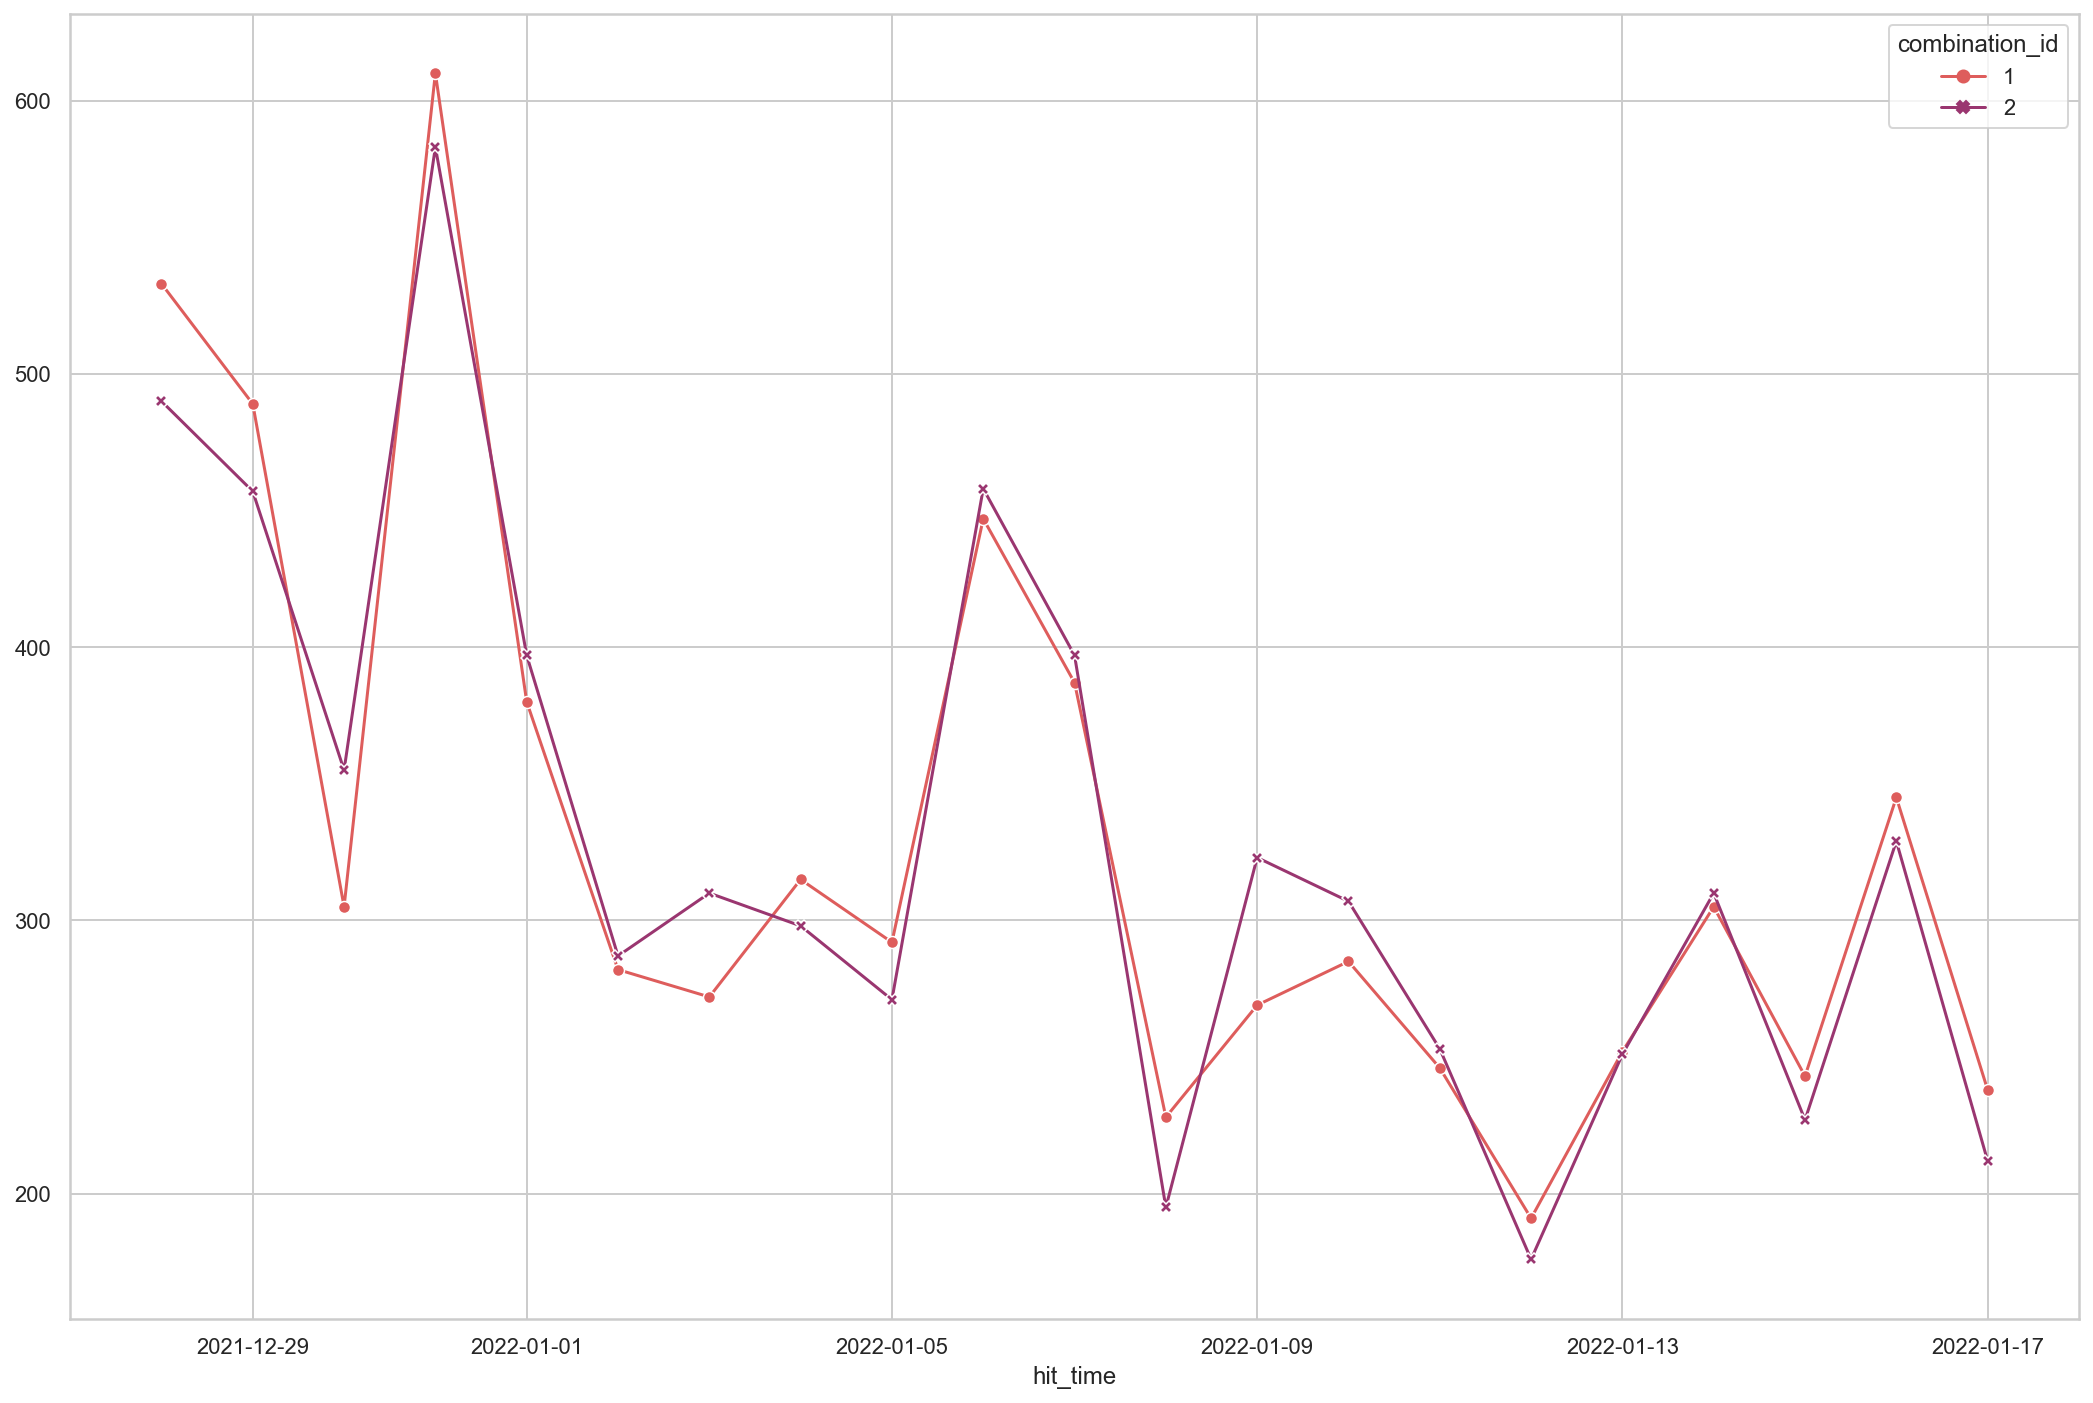

In [372]:
# RESAMPLE BY DAYS

gr = df.groupby([df['hit_time'].dt.date, df.combination_id]).size().unstack()
gr.index = gr.index.astype('datetime64[ns]')

sns.set_theme(style="whitegrid")
timeline = plt.subplots(figsize=(18, 12))
timeline = sns.lineplot(\
                       # height=12,\
                       # aspect=1.5,\
                       data=\
                       # df[df['combination_id']==1].groupby([df['hit_time'].dt.date]).size(),\
                       gr.resample('D').asfreq(),\
                       # kind="line",\
                       linewidth=1.5,\
                       markers=True,\
                       dashes=False,\
                       palette="flare", 
                      )
 


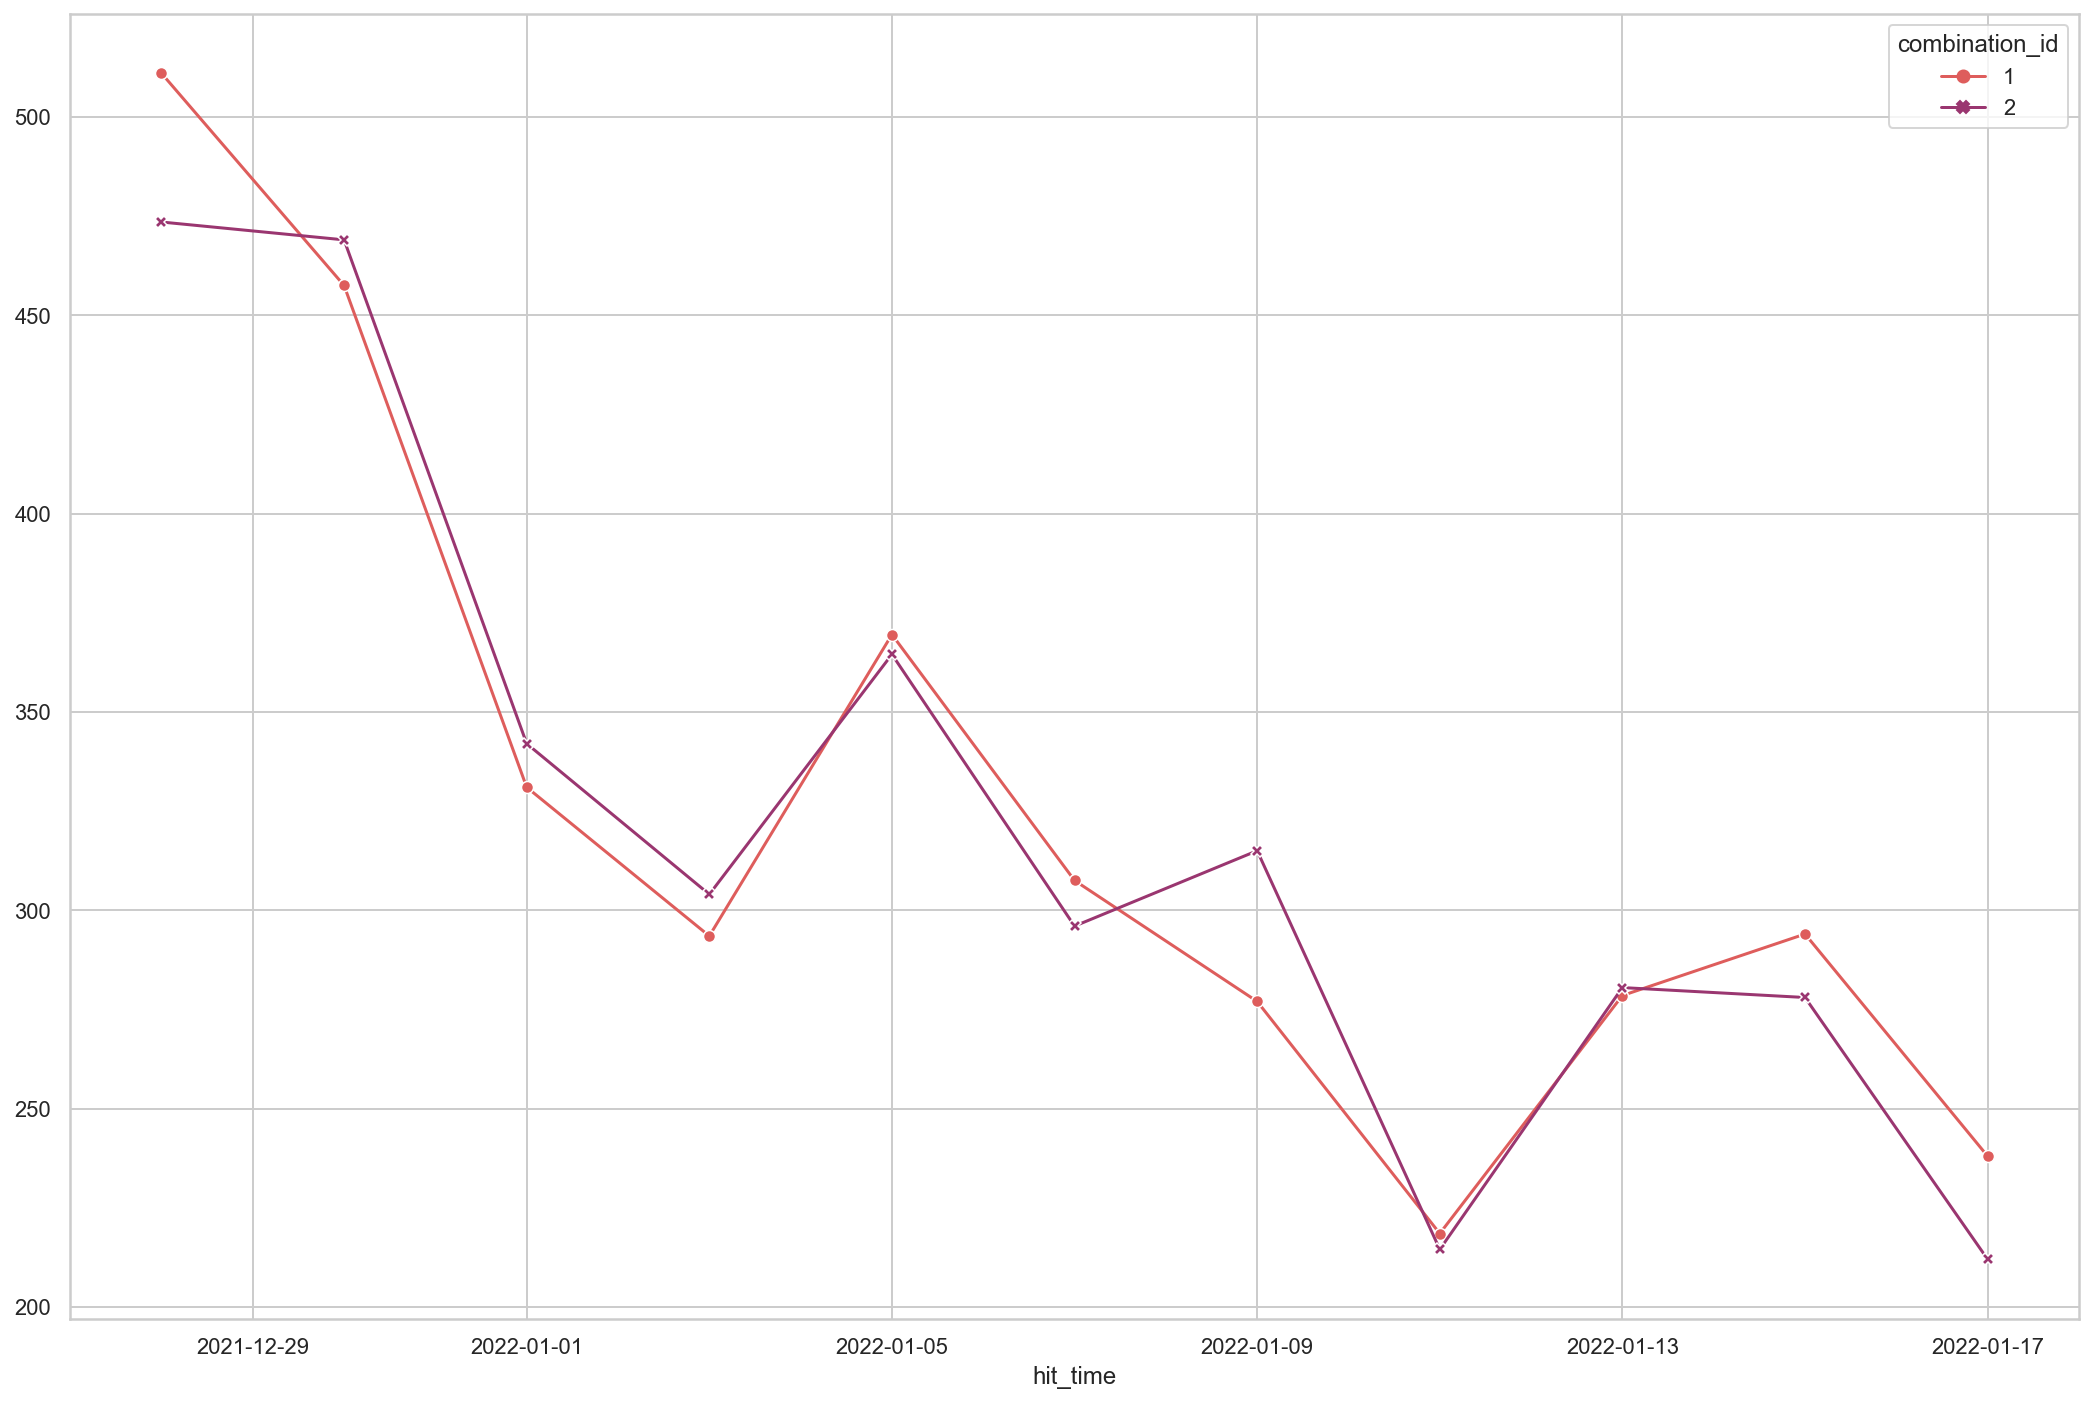

In [373]:
# RESAMPLE BY DAYS

gr = df.groupby([df['hit_time'].dt.date, df.combination_id]).size().unstack()
gr.index = gr.index.astype('datetime64[ns]')

sns.set_theme(style="whitegrid")
timeline = plt.subplots(figsize=(18, 12))
timeline = sns.lineplot(\
                       # height=12,\
                       # aspect=1.5,\
                       data=\
                       # df[df['combination_id']==1].groupby([df['hit_time'].dt.date]).size(),\
                       gr.resample('2D').mean(),\
                       # kind="line",\
                       linewidth=1.5,\
                       markers=True,\
                       dashes=False,\
                       palette="flare", 
                      )
 


variation groups order is [1, 2]


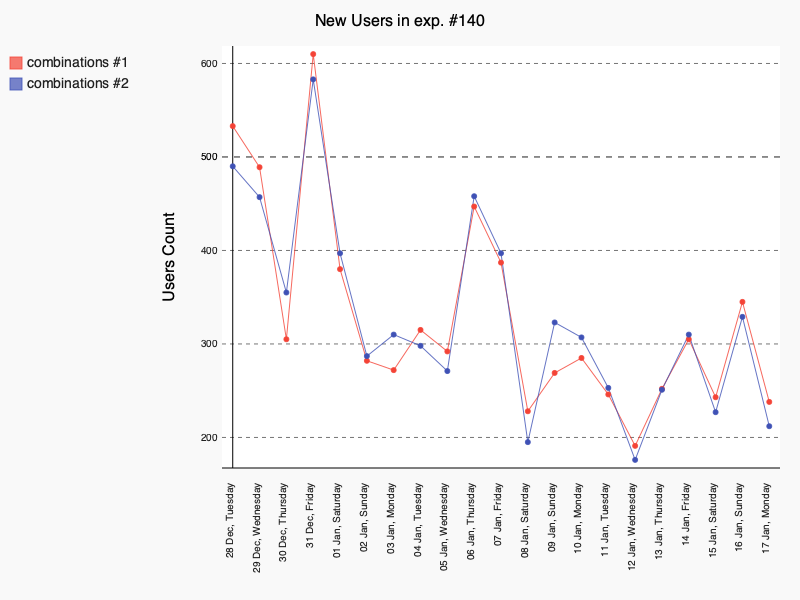

In [374]:
# Draw new user visits on DataTime Scale

factor = list(df['combination_id'].unique())
factor.sort()
date_chart = pygal.Line\
    (
#      fill=True,\
     x_label_rotation=270,\
     x_value_formatter=lambda dt: dt.strftime('%d %b, %A'),\
     y_title='Users Count')
date_chart.x_labels = df['hit_time'].dt.date.unique()

date_chart.title = 'New Users in exp. #{}'.format(exp)


for x in range(len(factor)):
    viz = date_chart.add('combinations #{}'.format(x+1), list(df[df['combination_id']==factor[x]].groupby([df['hit_time'].dt.date]).size()))
print('variation groups order is', factor)
date_chart

date_chart.render_to_file('/Users/rodiontereshkov/Downloads/new_visitors_exp{}.svg'.format(exp))

In [375]:
df.groupby([df['hit_time'].dt.date]).size().asfreq('2D').index

DatetimeIndex(['2021-12-28', '2021-12-30', '2022-01-01', '2022-01-03',
               '2022-01-05', '2022-01-07', '2022-01-09', '2022-01-11',
               '2022-01-13', '2022-01-15', '2022-01-17'],
              dtype='datetime64[ns]', name='hit_time', freq='2D')

variation groups order is [1, 2]


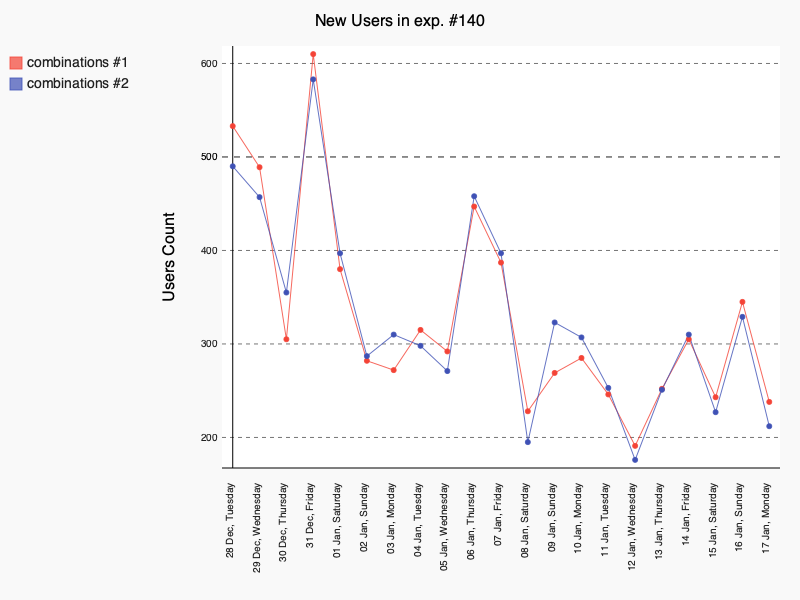

In [376]:
# Draw new user visits on DataTime Scale

factor = list(df['combination_id'].unique())
factor.sort()
date_chart = pygal.Line\
    (
#      fill=True,\
     x_label_rotation=270,\
     x_value_formatter=lambda dt: dt.strftime('%d %b, %A'),\
     y_title='Users Count')
date_chart.x_labels = df.groupby([df['hit_time'].dt.date]).size().asfreq('D').index

date_chart.title = 'New Users in exp. #{}'.format(exp)


for x in range(len(factor)):
    viz = date_chart.add('combinations #{}'.format(x+1), list(df[df['combination_id']==factor[x]].groupby([df['hit_time'].dt.date]).size()))
print('variation groups order is', factor)
date_chart

date_chart.render_to_file('/Users/rodiontereshkov/Downloads/new_visitors_exp{}.svg'.format(exp))

#### Draw Goals day by day

variation groups order is [1, 2]


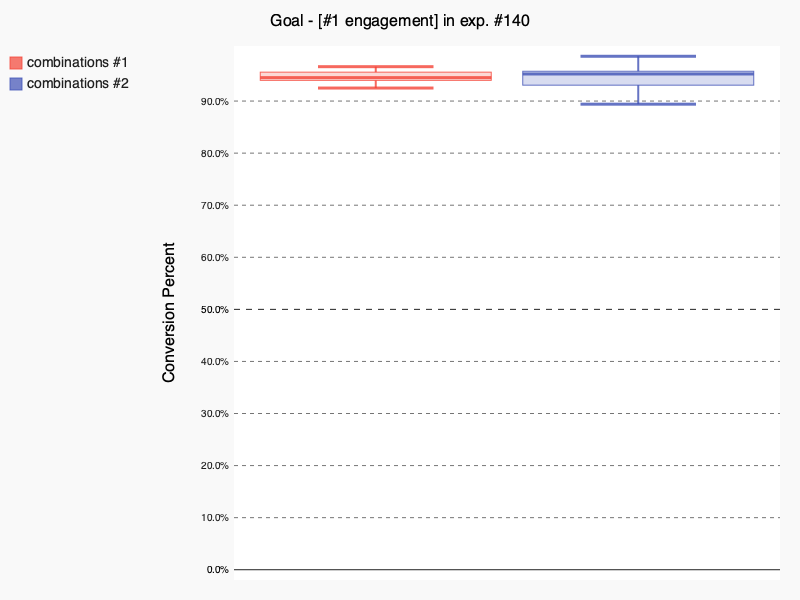

variation groups order is [1, 2]


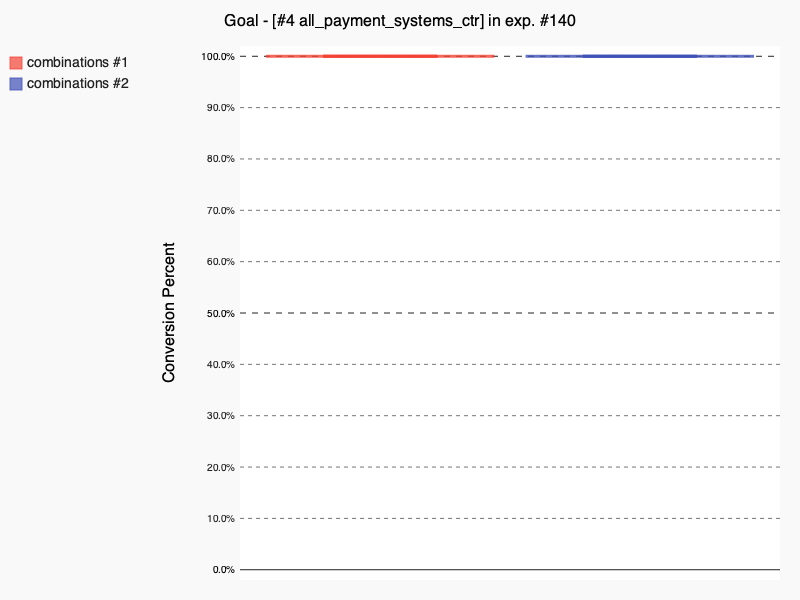

variation groups order is [1, 2]


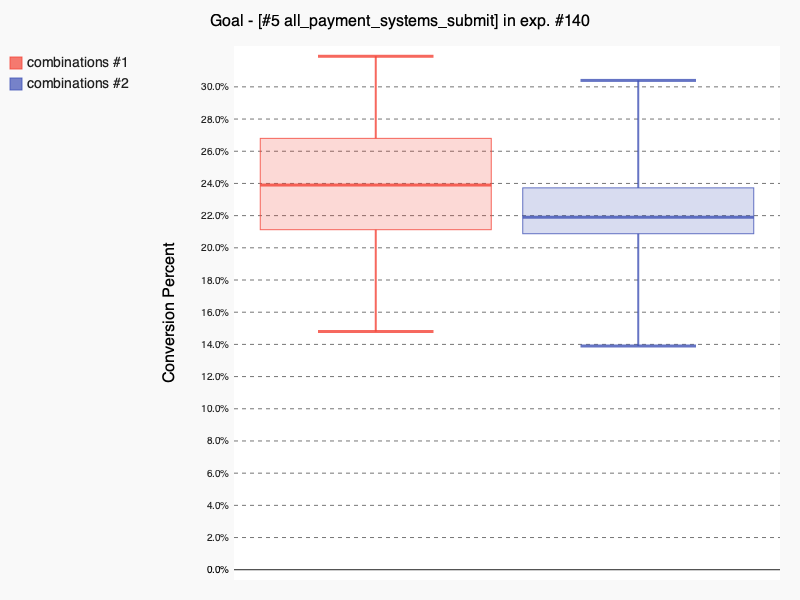

variation groups order is [1, 2]


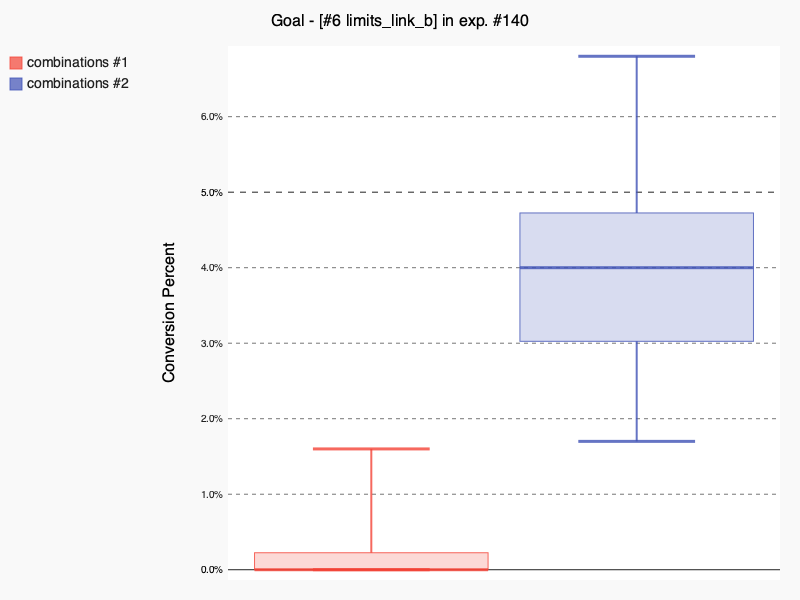

variation groups order is [1, 2]


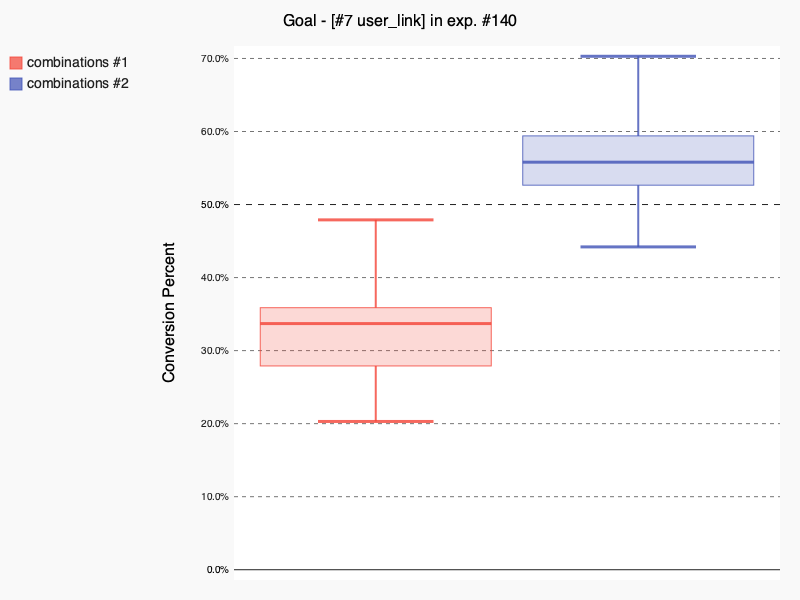

variation groups order is [1, 2]


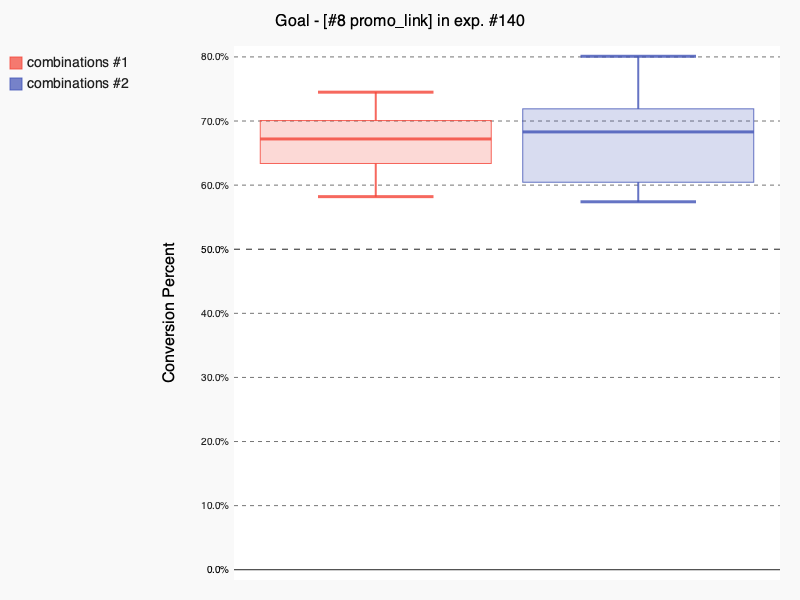

variation groups order is [1, 2]


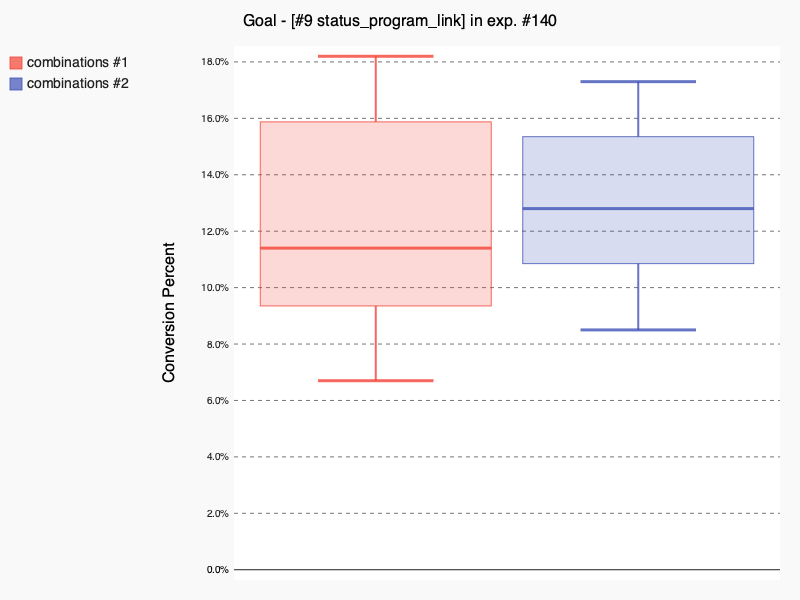

variation groups order is [1, 2]


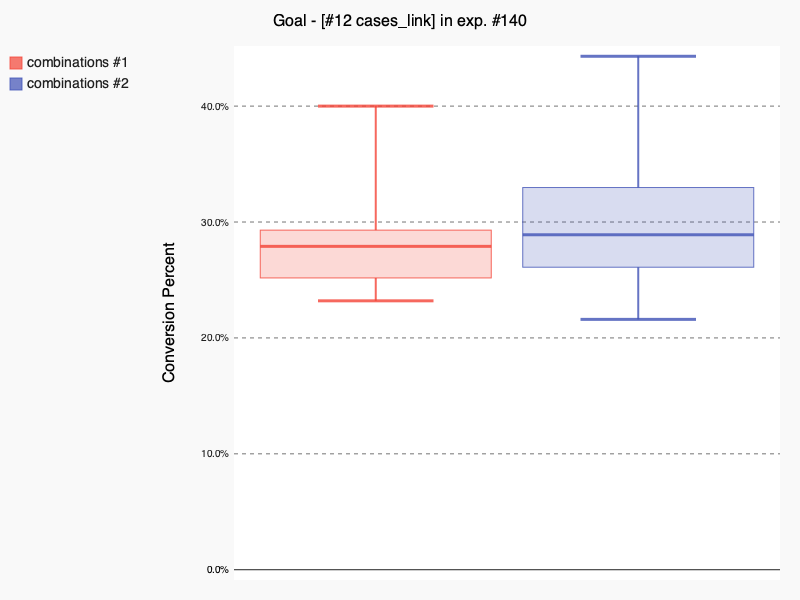

variation groups order is [1, 2]


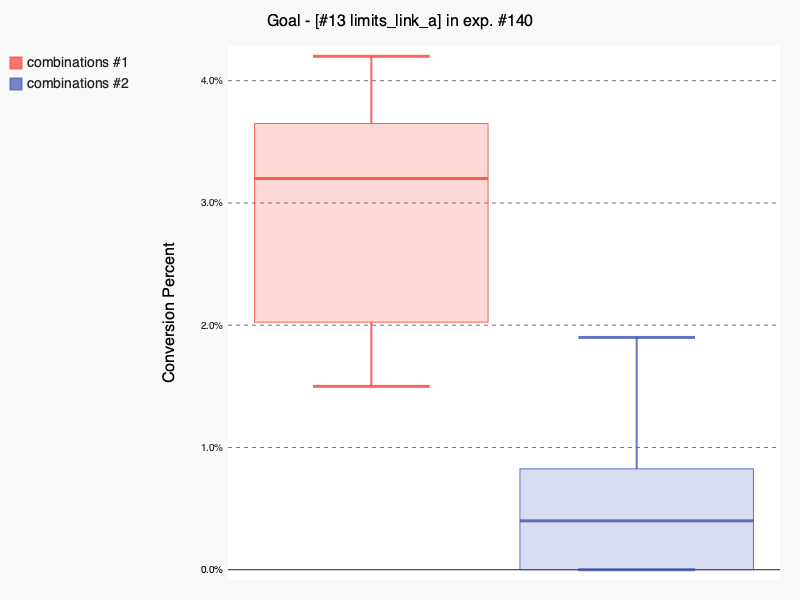

variation groups order is [1, 2]


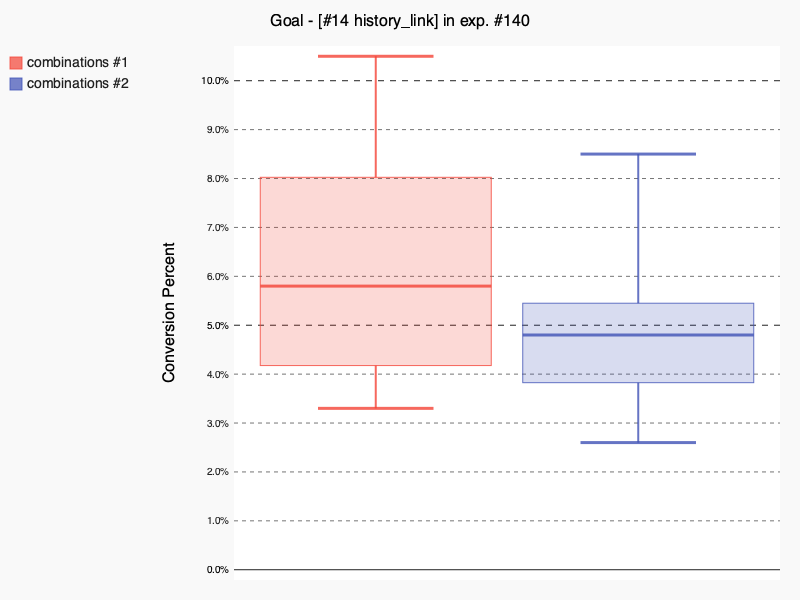

variation groups order is [1, 2]


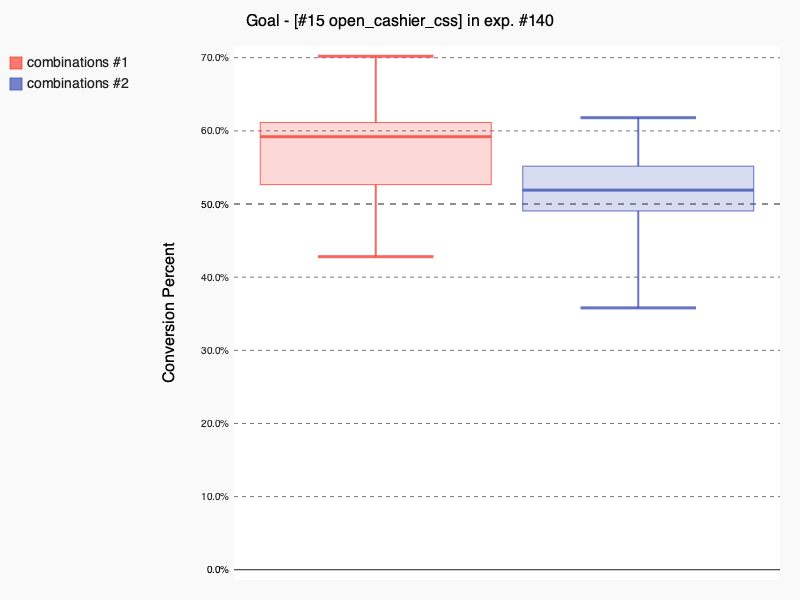

variation groups order is [1, 2]


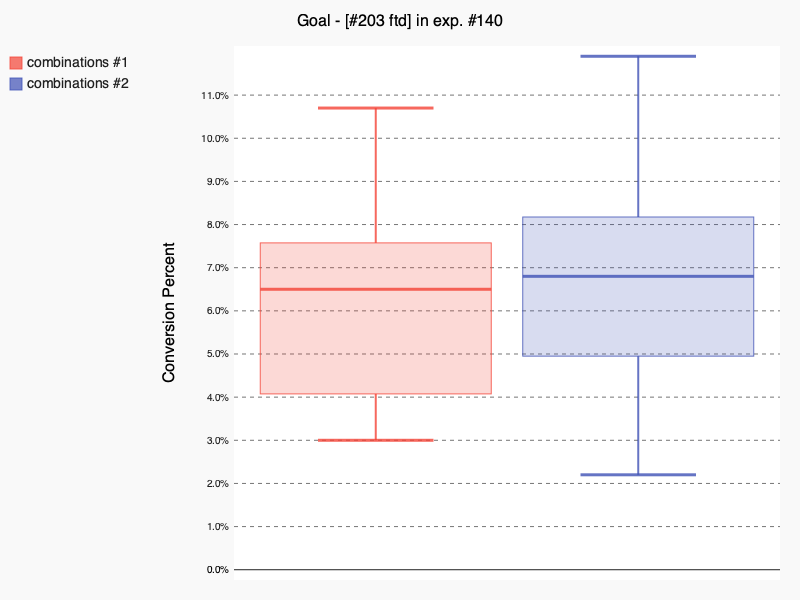

variation groups order is [1, 2]


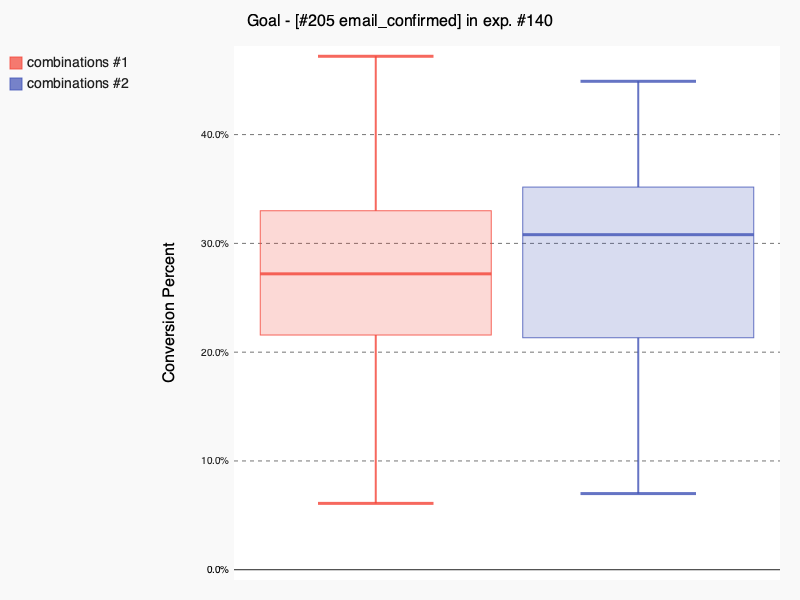

variation groups order is [1, 2]


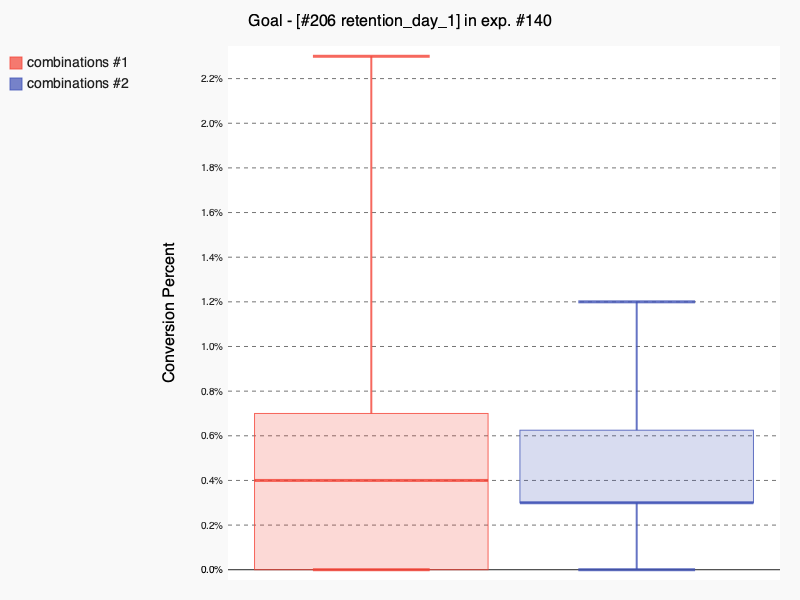

variation groups order is [1, 2]


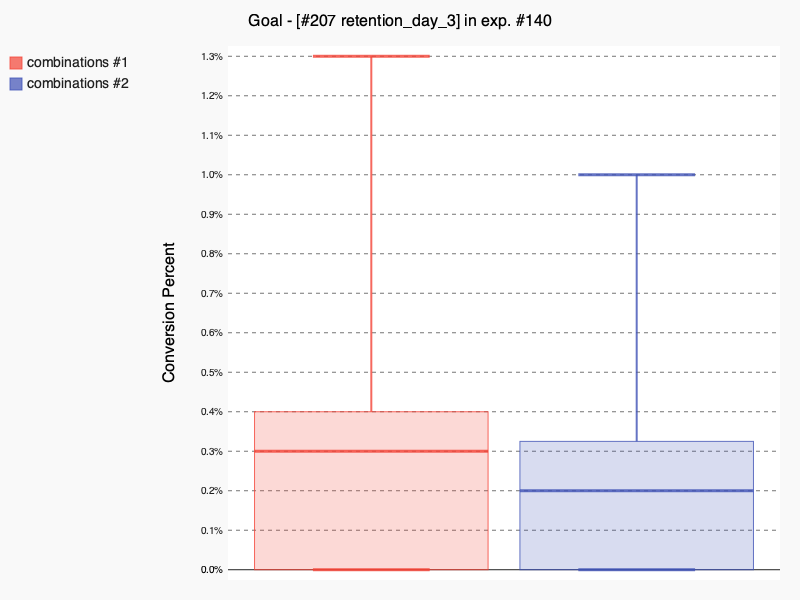

variation groups order is [1, 2]


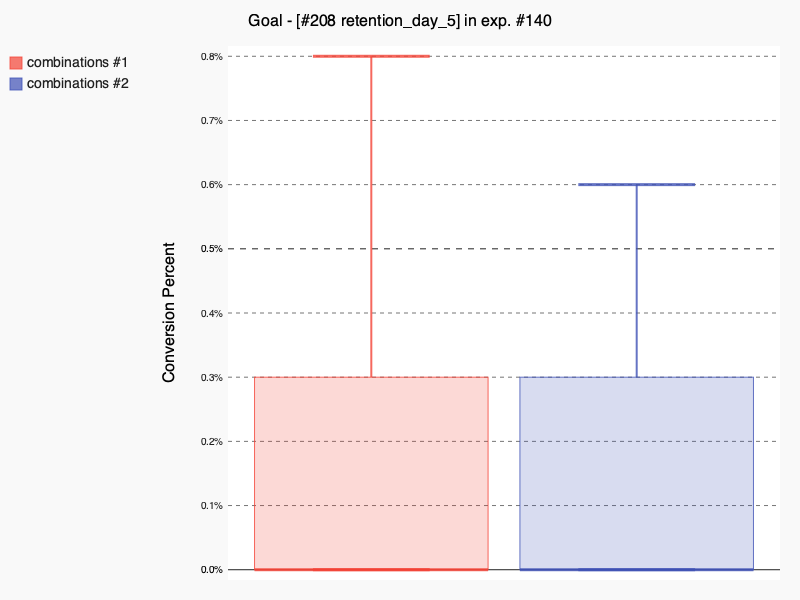

variation groups order is [1, 2]


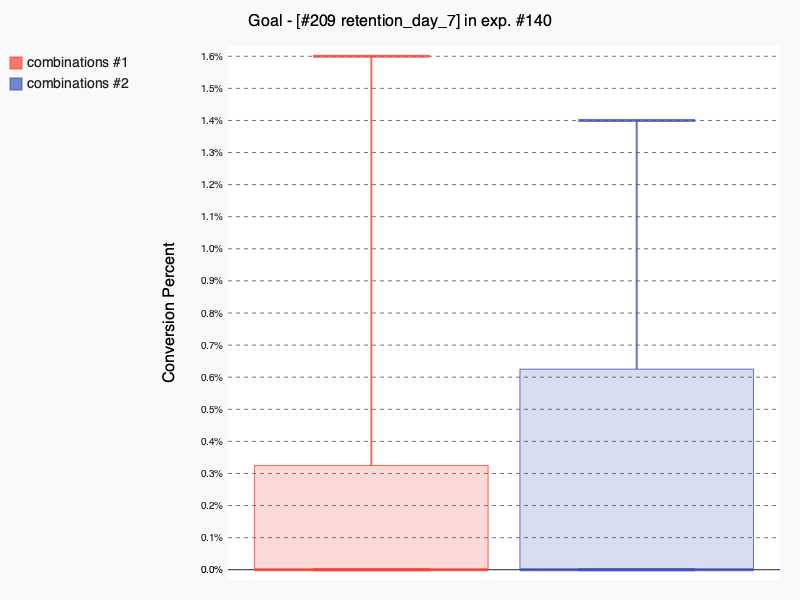

variation groups order is [1, 2]


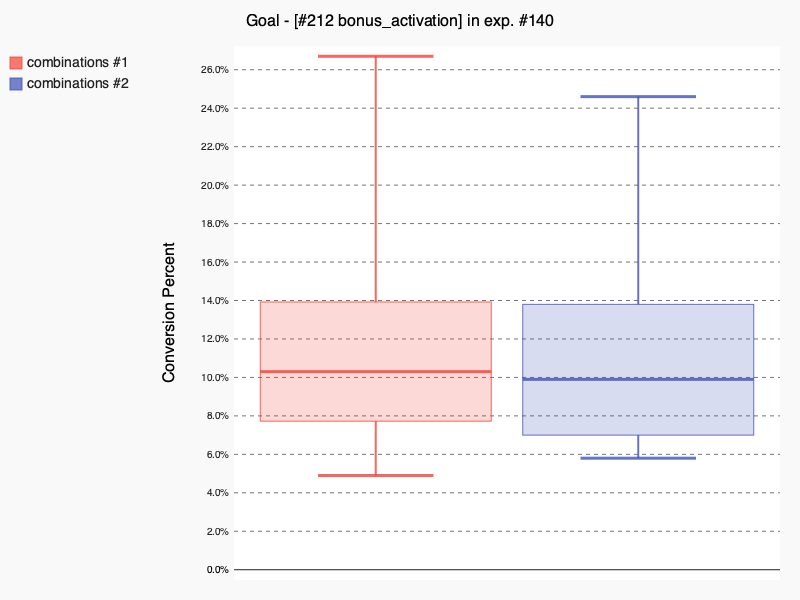

variation groups order is [1, 2]


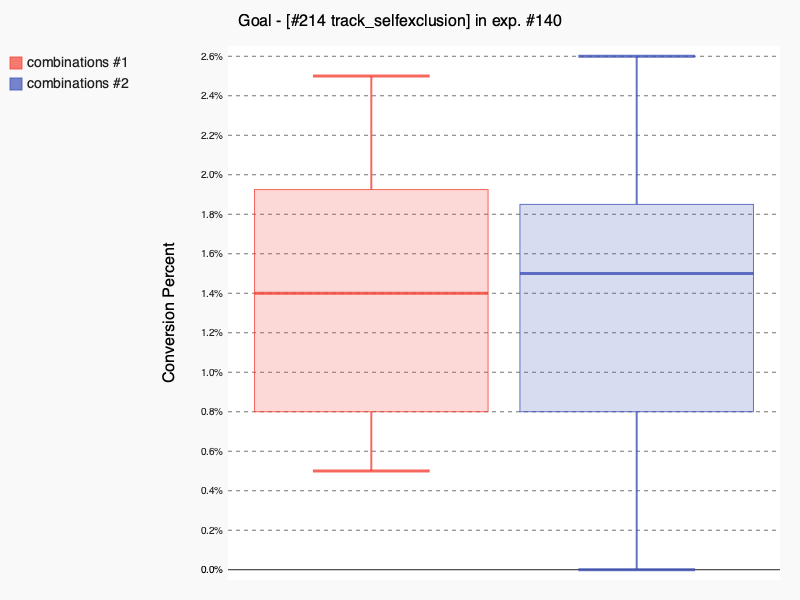

variation groups order is [1, 2]


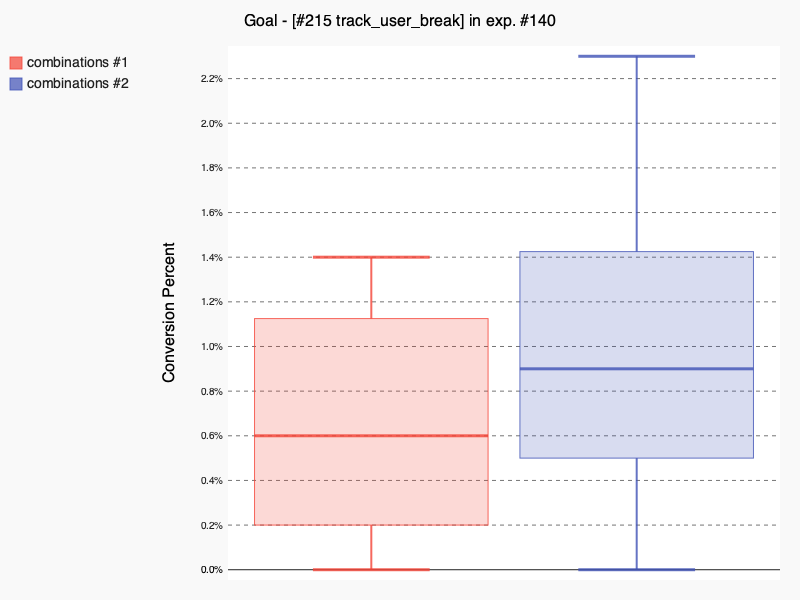

In [377]:
# Draw new user visits on DataTime Scale
goal_ids = meta['id'][:-3]

for goal_id in goal_ids:
    goal_name = meta[meta['id']==goal_id].name.values[0]
    factor = list(df['combination_id'].unique())
    factor.sort()
    date_chart = pygal.Box\
        (\
         fill=True,\
         x_label_rotation=270,\
         x_value_formatter=lambda dt: dt.strftime('%d %b, %A'),\
         value_formatter = lambda x:'{}%'.format(round(x*100, 4)),\
         y_title='Conversion Percent')
#     date_chart.x_labels = df['hit_time'].dt.date.unique()
    date_chart.title = 'Goal - [#{} {}] in exp. #{}'.format(goal_id, goal_name, exp)


    for x in range(len(factor)):
        viz = date_chart.add('combinations #{}'.format(x+1),
                             list(df[df['combination_id']==factor[x]]\
                                  .groupby([df['hit_time'].dt.date])\
                                  ['goal_{}_converted'.format(goal_id)].value_counts(normalize=True).unstack().iloc[:, -1].fillna(0).round(3)))
    print('variation groups order is', factor)
    date_chart
    # date_chart.render_to_file('/Users/rodiontereshkov/Downloads/goal_{}_exp_{}_{}.svg'.format(goal_id, exp, today))

## CORRELATION ANALYSIS

In [379]:
meta

category   id                                        name  \
0          goal    1                                  engagement   
1          goal    4                     all_payment_systems_ctr   
2          goal    5                  all_payment_systems_submit   
3          goal    6                               limits_link_b   
4          goal    7                                   user_link   
5          goal    8                                  promo_link   
6          goal    9                         status_program_link   
7          goal   12                                  cases_link   
8          goal   13                               limits_link_a   
9          goal   14                                history_link   
10         goal   15                            open_cashier_css   
11         goal  203                                         ftd   
12         goal  205                             email_confirmed   
13         goal  206                             retention_day_1   
14         goal  207                             retention_day_3   
15         goal  208                             retention_day_5   
16         goal  209                             retention_day_7   
17         goal  212                            bonus_activation   
18         goal  214                         track_selfexclusion   
19         goal  215                            track_user_break   
20  combination    1                                     Control   
21  combination    2                                 Variation 1   
22     campaign  140  [SC-6665][ABT-58] Redesign of User Profile   

                 type    created_timestamp  info  
0          engagement  2021-11-18 10:26:51   NaN  
1        clickElement  2021-11-18 10:26:51   NaN  
2        clickElement  2021-11-18 10:26:51   NaN  
3           clickLink  2021-12-27 13:09:59   NaN  
4           clickLink  2021-12-27 13:10:44   NaN  
5           clickLink  2021-12-27 13:11:39   NaN  
6           clickLink  2021-12-27 13:12:24   NaN  
7           clickLink  2021-12-27 13:14:36   NaN  
8           clickLink  2021-12-27 13:34:47   NaN  
9           clickLink  2021-12-27 13:42:34   NaN  
10       clickElement  2021-12-27 13:53:42   NaN  
11  custom-conversion  2021-11-18 10:26:51   NaN  
12  custom-conversion  2021-12-27 13:16:05   NaN  
13  custom-conversion  2021-11-18 10:26:51   NaN  
14  custom-conversion  2021-11-18 10:26:51   NaN  
15  custom-conversion  2021-11-18 10:26:51   NaN  
16  custom-conversion  2021-11-18 10:26:51   NaN  
17  custom-conversion  2021-11-18 10:26:51   NaN  
18  custom-conversion  2021-12-03 14:06:02   NaN  
19  custom-conversion  2021-12-03 14:06:02   NaN  
20                NaN                  NaN   NaN  
21                NaN                  NaN   NaN  
22                NaN                  NaN   NaN

In [381]:
converted = list(df.columns[df.columns.str.endswith('_converted')])
unwanted = ['goal_206_converted','goal_207_converted',]
converted = [elem for elem in converted  if elem not in unwanted]

Text(0.5, 1.0, 'CORRELATION ANALYSIS for ALL GROUPS TOGETHER')

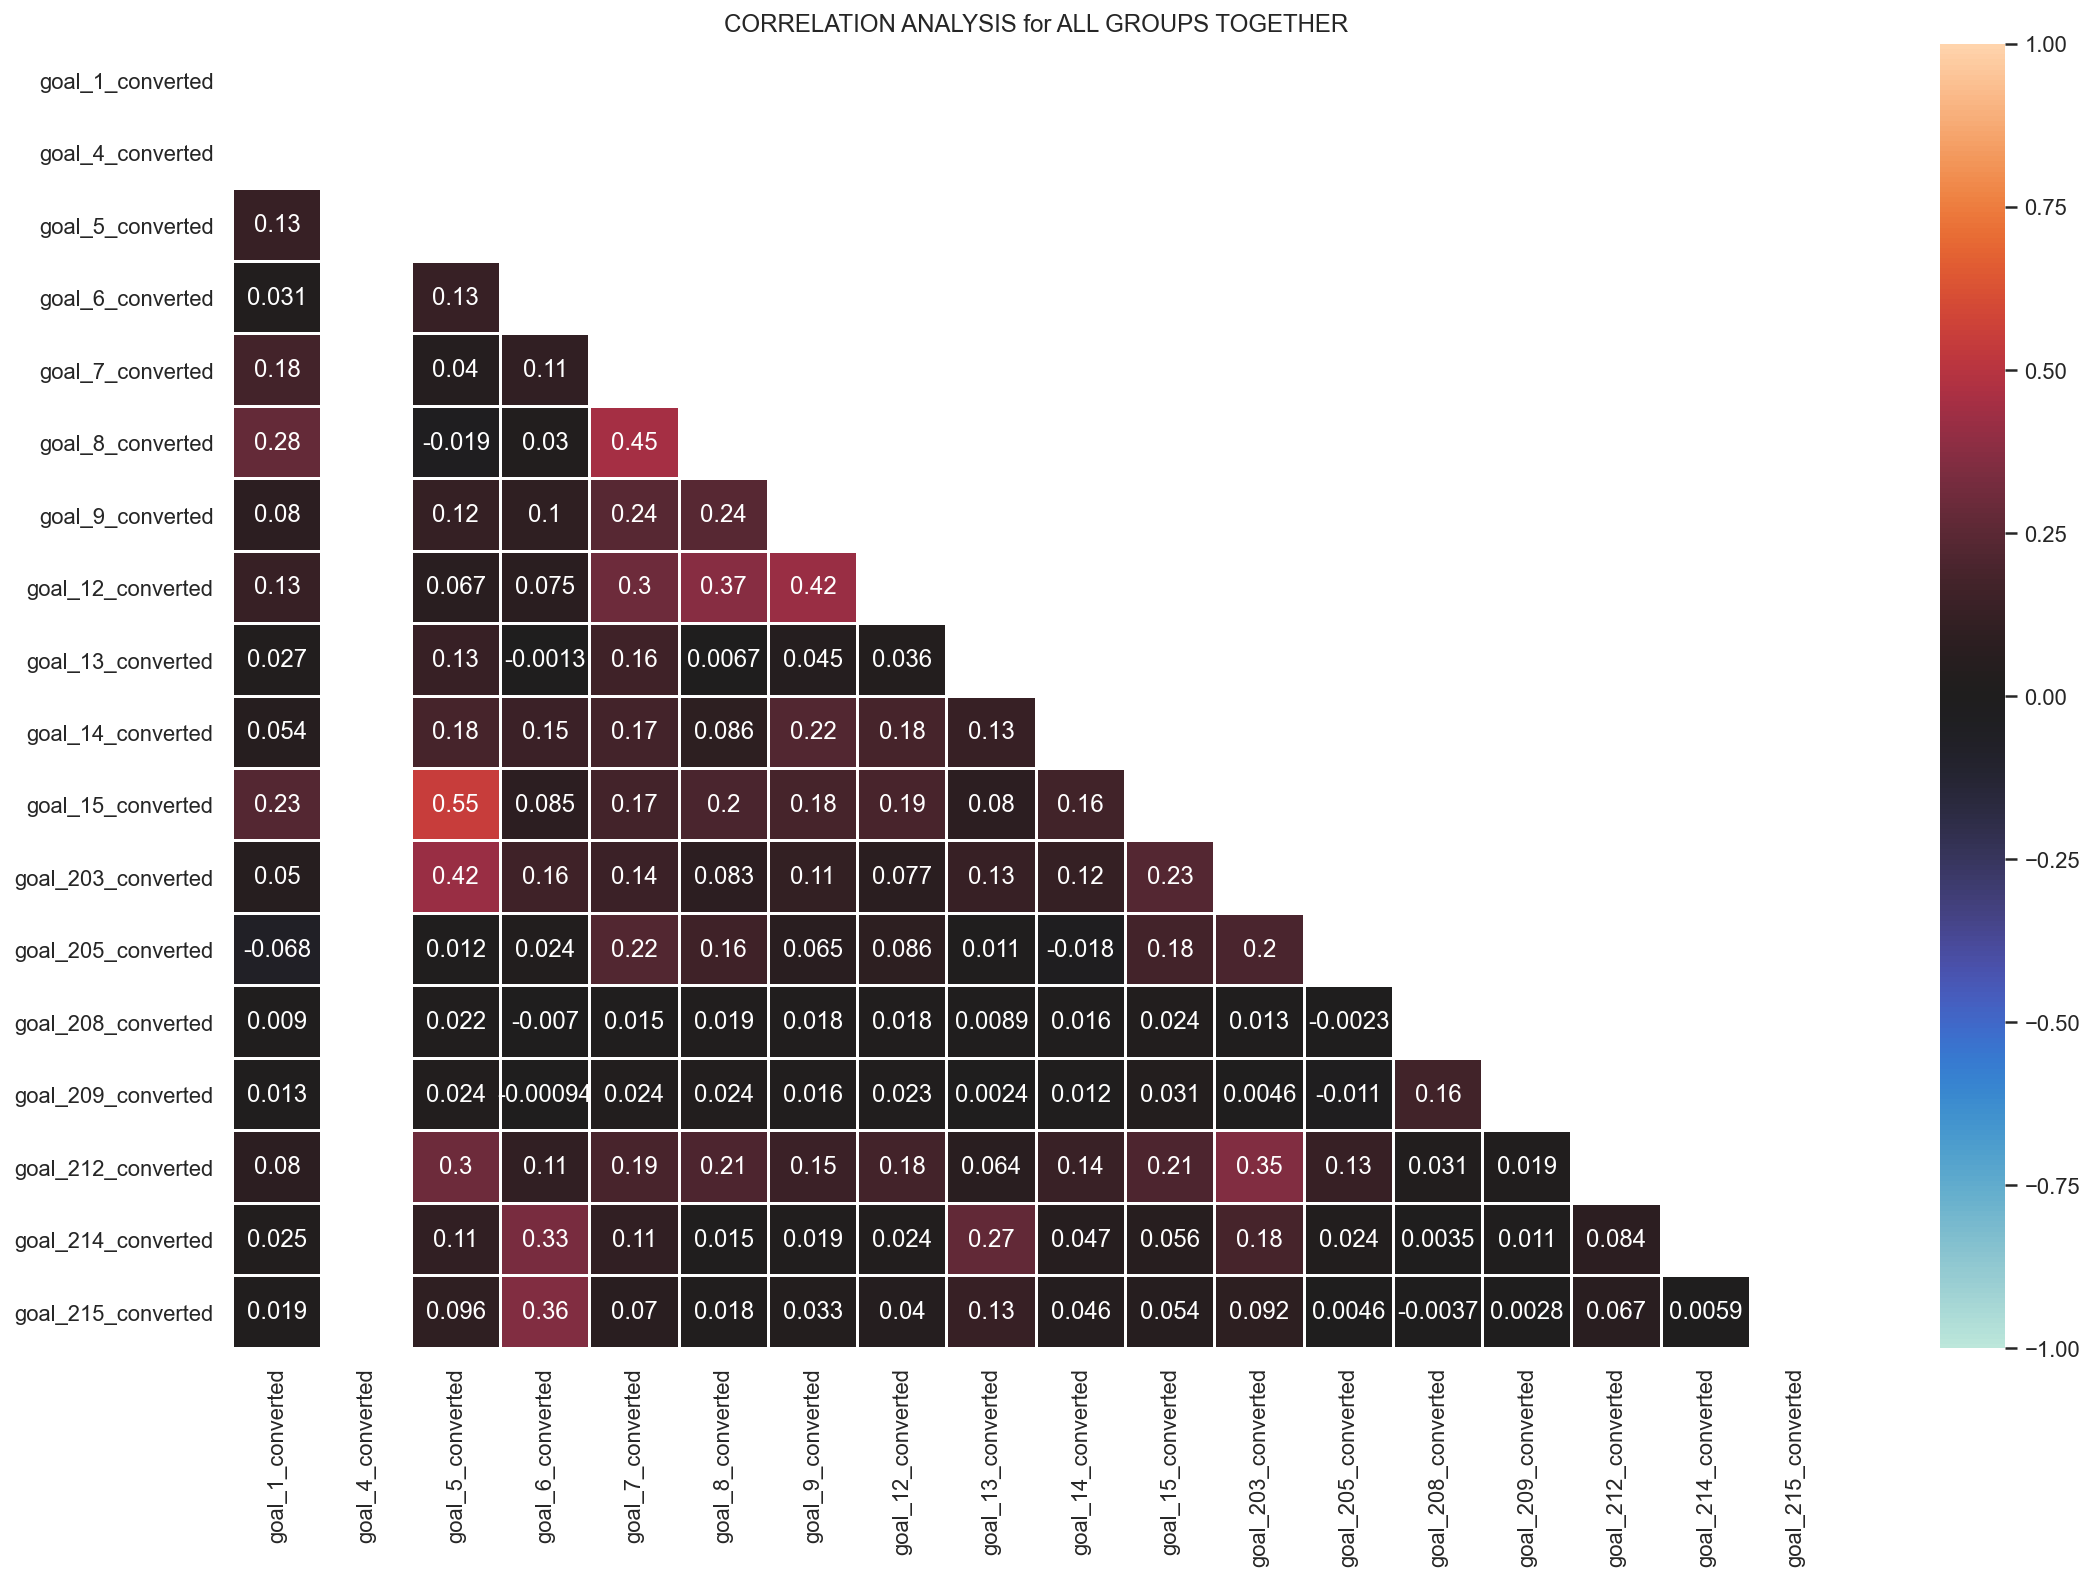

In [382]:
corr_new = df_goals[converted].corr()
mask = np.zeros_like(corr_new)
mask[np.triu_indices_from(mask)] = True

ax_nulls = plt.subplots(figsize=(18, 12))
ax_nulls = plt.subplot(111)
ax_nulls = sns.heatmap(corr_new,\
                      mask=mask,\
                      vmin=-1, vmax=1, annot=True, linewidths=1, center=0
                      )

ax_nulls.set_title('CORRELATION ANALYSIS for ALL GROUPS TOGETHER')

#### CORRELATION FOR EACH GROUP SEPARATELY

Text(0.5, 1.0, 'CORRELATION ANALYSIS for GROUP #1')

Text(0.5, 1.0, 'CORRELATION ANALYSIS for GROUP #2')

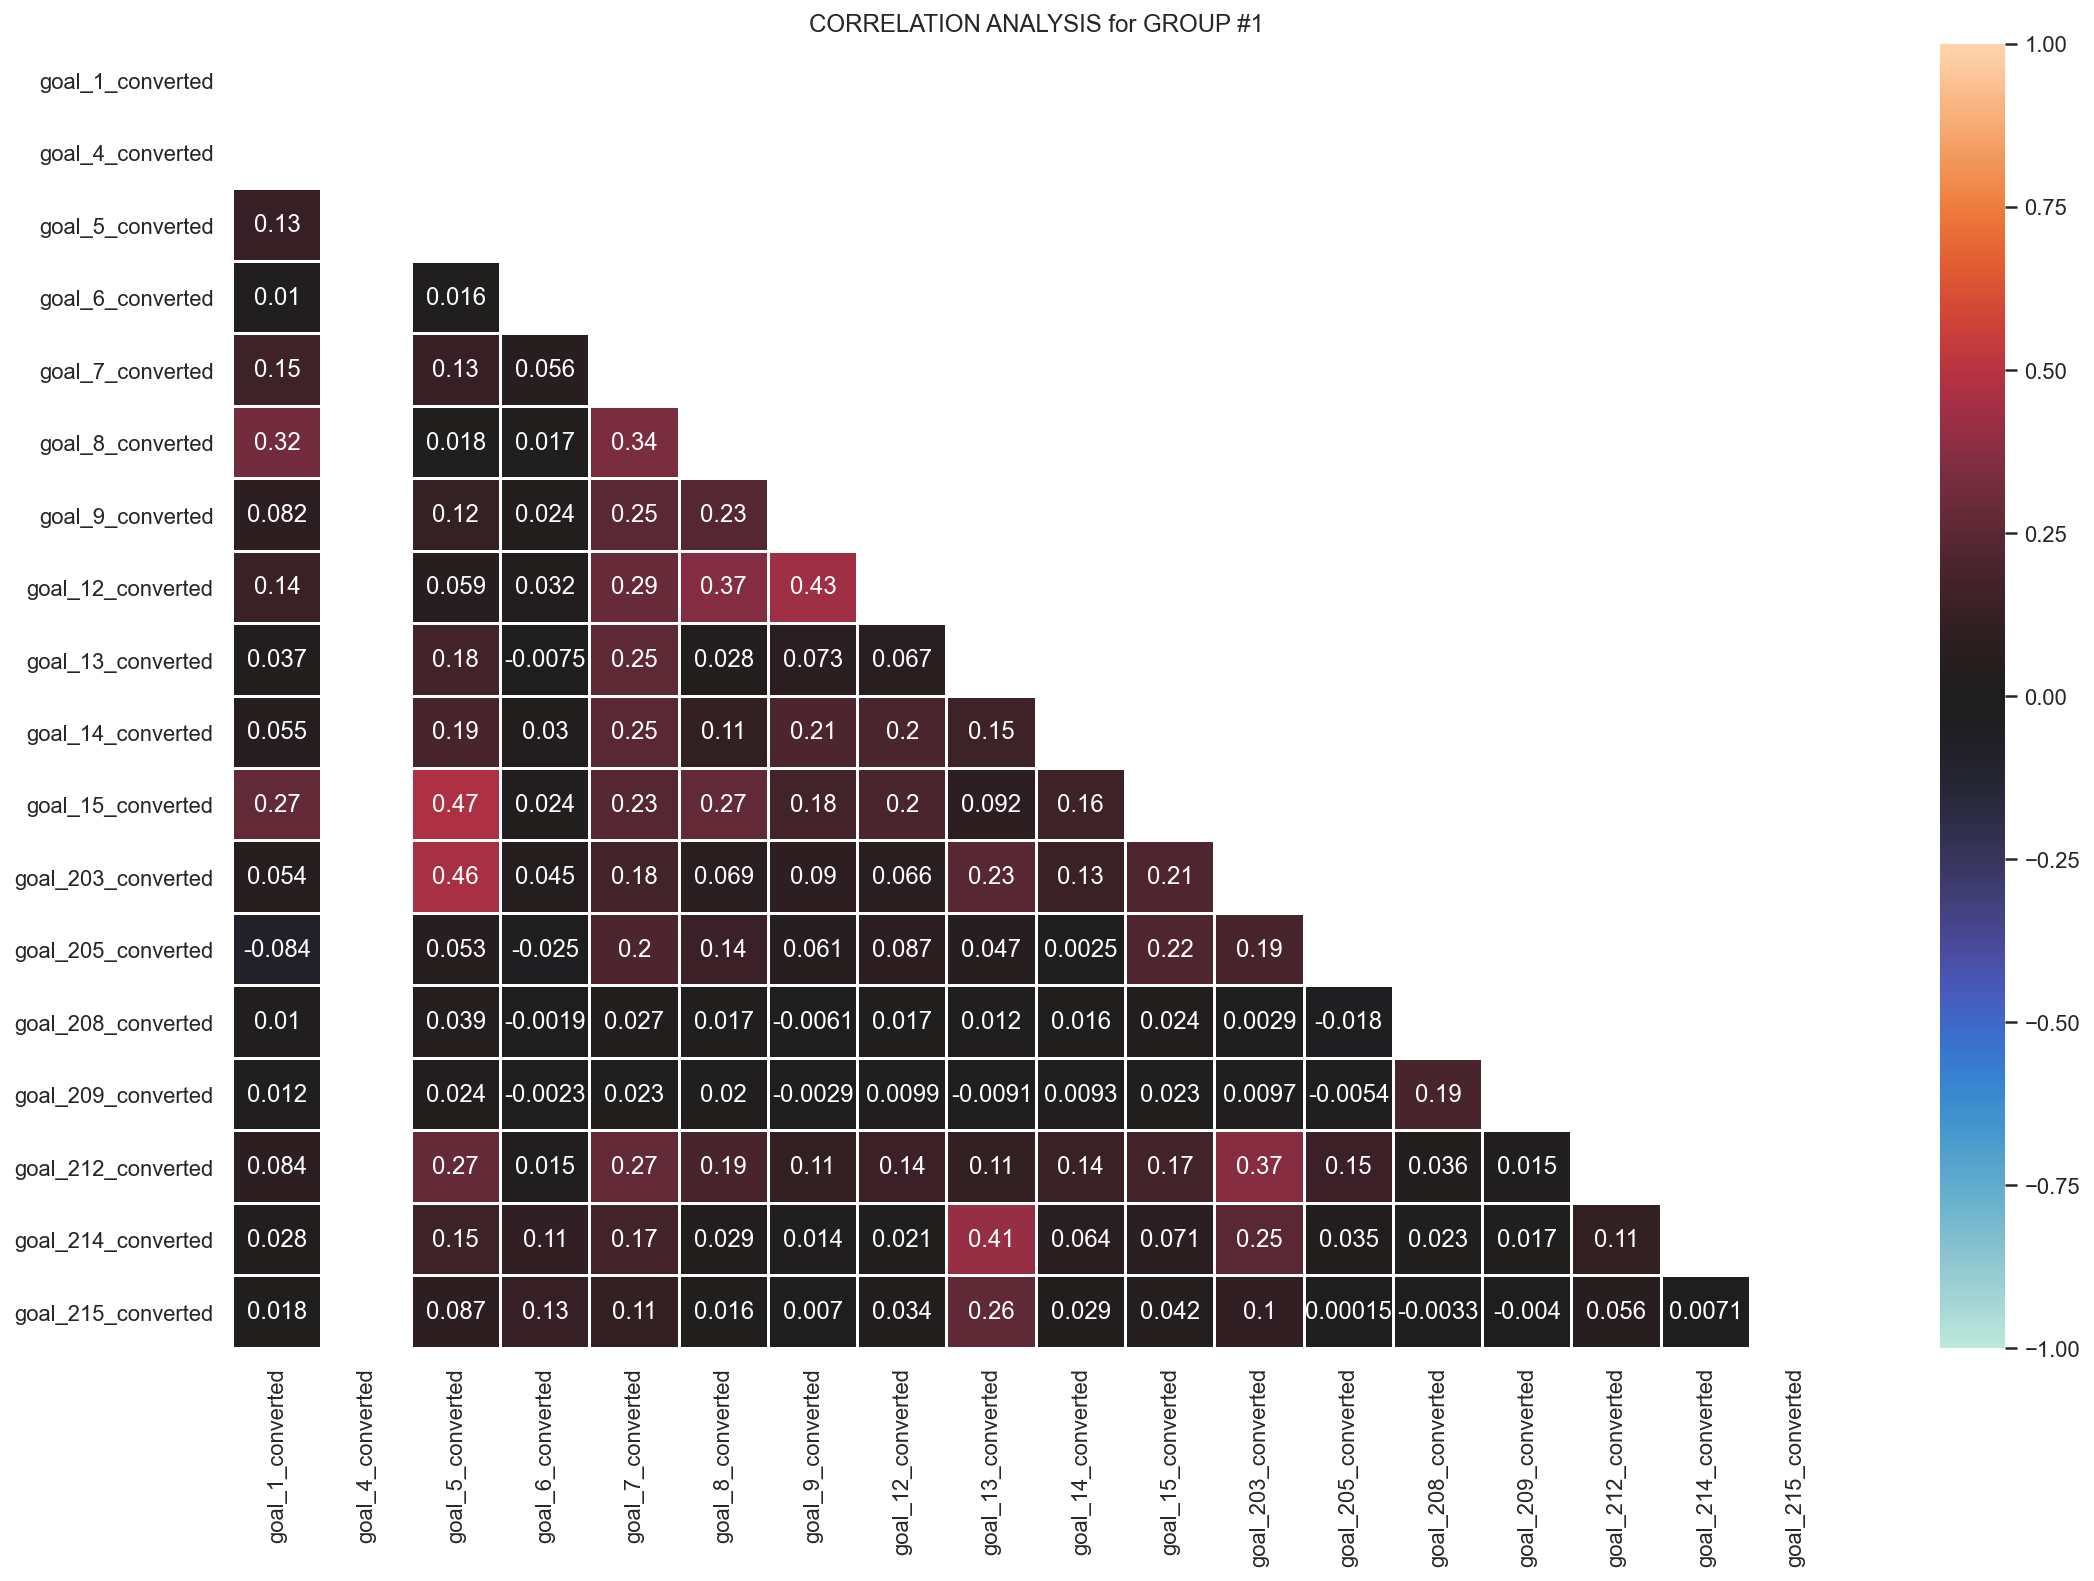

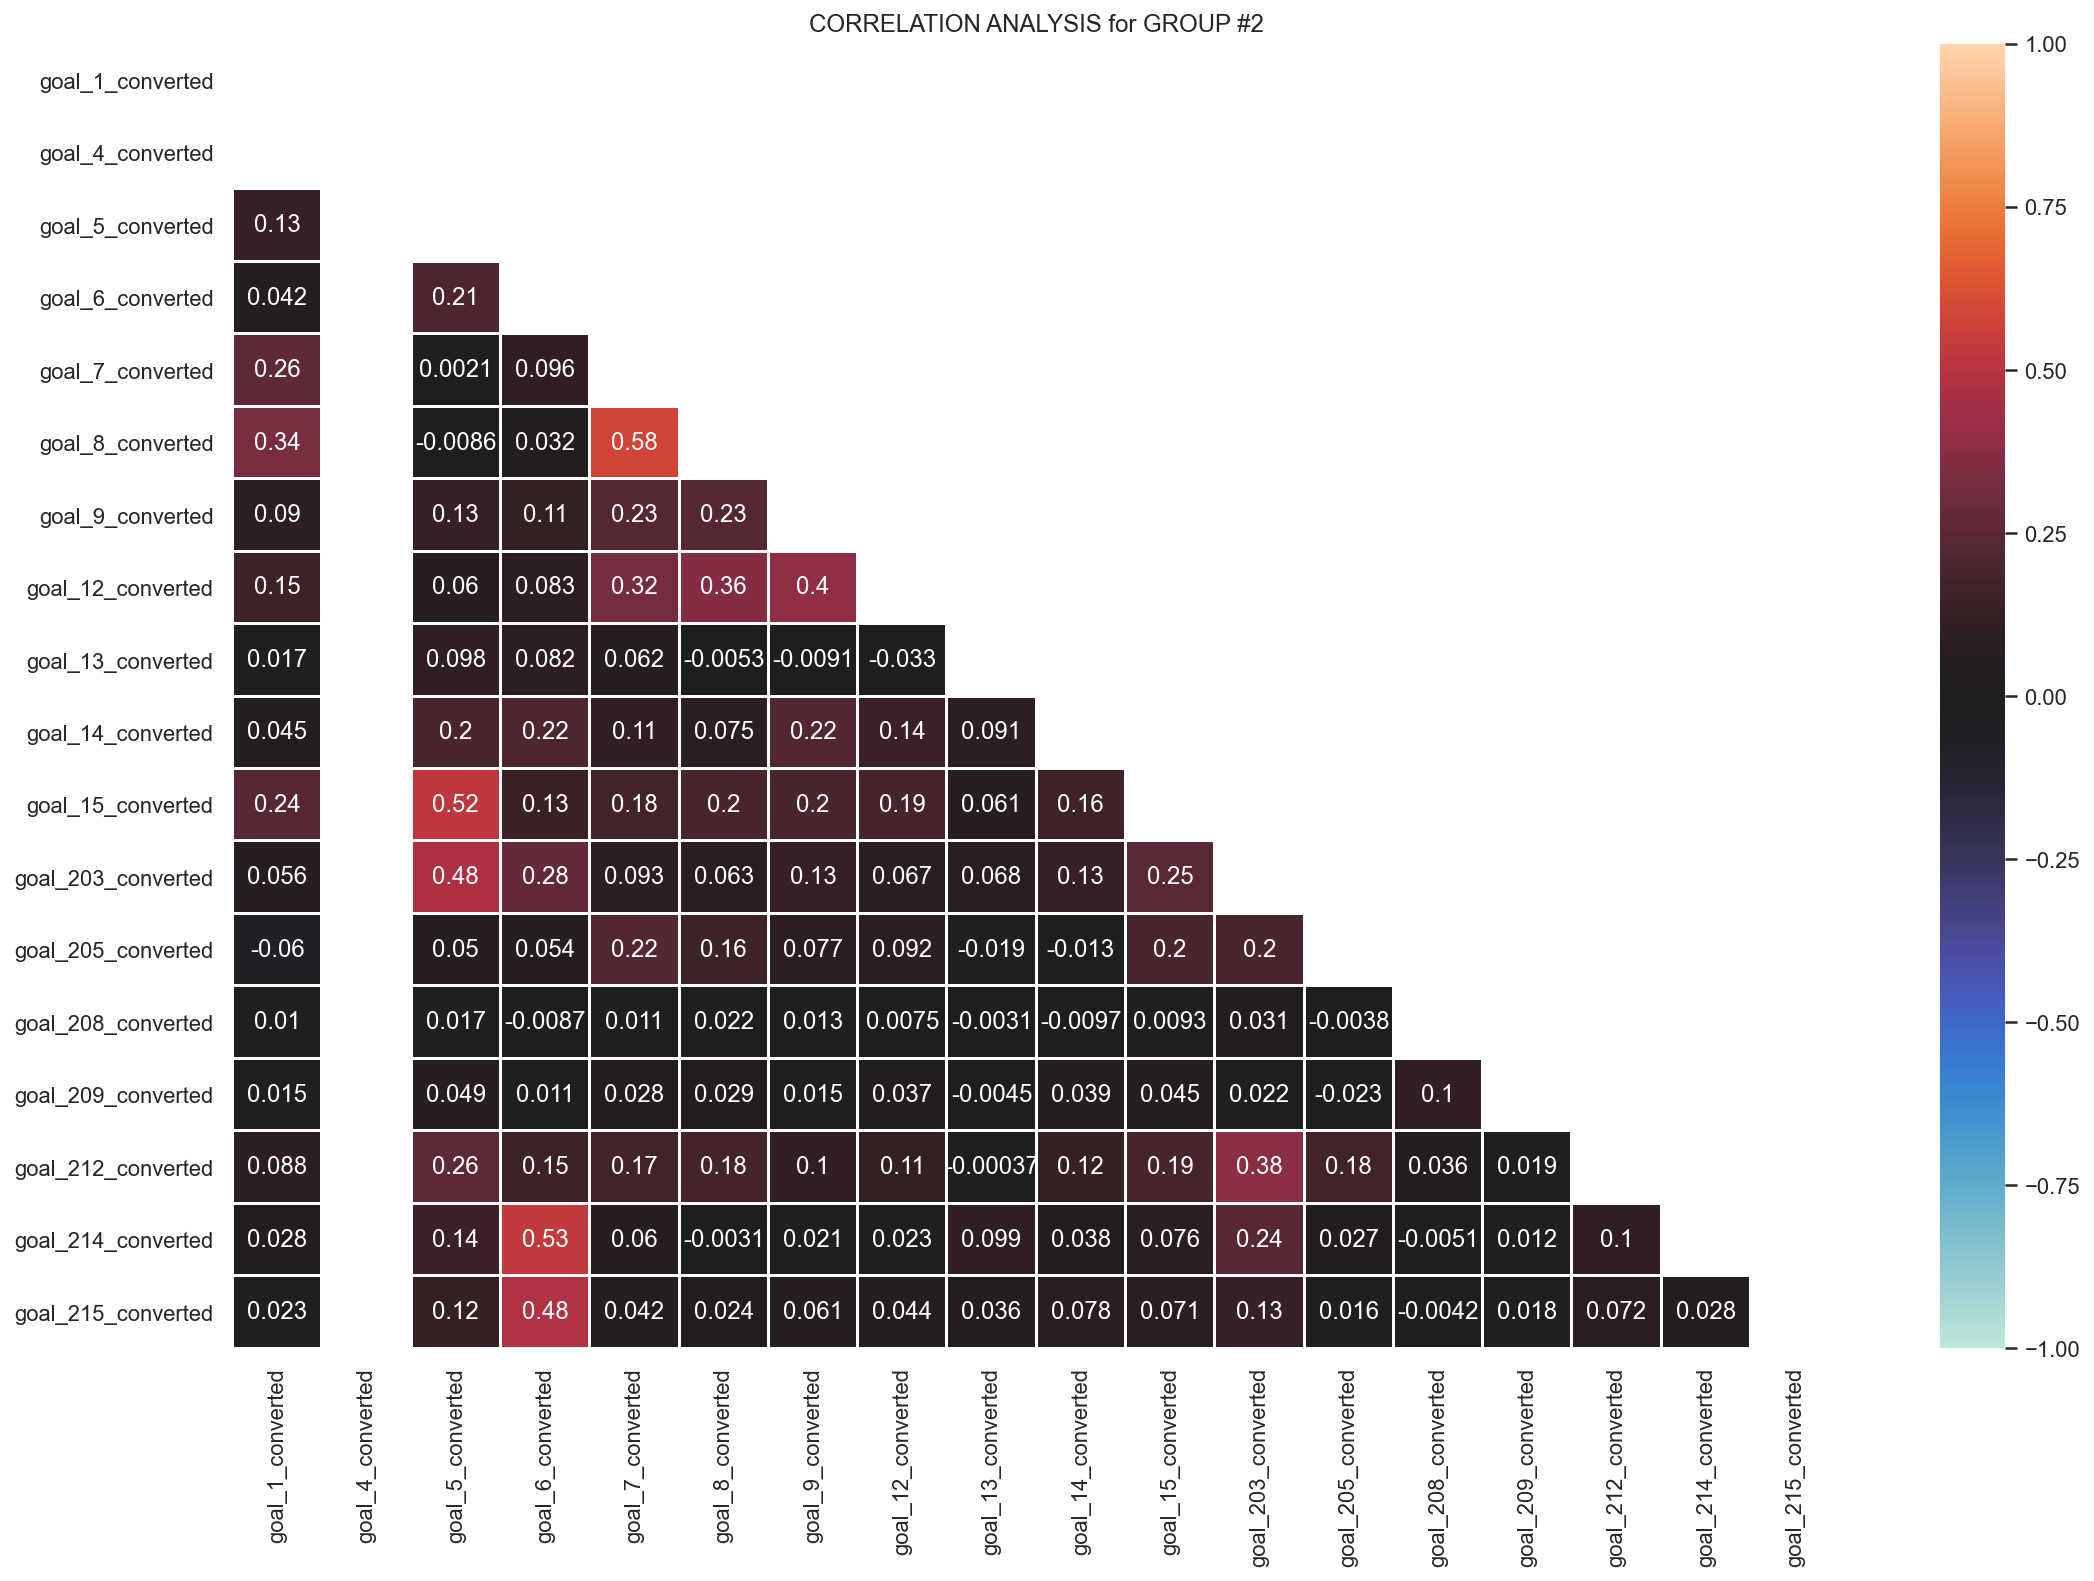

In [383]:
for x in range(1, df.combination_id.nunique()+1):
    corr_new = df[df['combination_id'] == x][converted].corr()
    mask = np.zeros_like(corr_new)
    mask[np.triu_indices_from(mask)] = True
    
    
    ax_nulls = plt.subplots(figsize=(18, 12))
    ax_nulls = sns.heatmap(corr_new,\
                          mask=mask,\
                          vmin=-1, vmax=1, annot=True, linewidths=1, center=0
                          )
    ax_nulls.set_title('CORRELATION ANALYSIS for GROUP #{}'.format(x))

In [384]:
df.groupby('combination_id').size()

combination_id
1    6914
2    6886
dtype: int64

In [385]:
df.shape

(13800, 93)

## P-VALUES

In [28]:
meta.iloc[:, :-1]

category   id                                        name  \
0          goal    1                                  engagement   
1          goal    4                     all_payment_systems_ctr   
2          goal    5                  all_payment_systems_submit   
3          goal    6                               limits_link_b   
4          goal    7                                   user_link   
5          goal    8                                  promo_link   
6          goal    9                         status_program_link   
7          goal   12                                  cases_link   
8          goal   13                               limits_link_a   
9          goal   14                                history_link   
10         goal   15                            open_cashier_css   
11         goal  203                                         ftd   
12         goal  205                             email_confirmed   
13         goal  206                             retention_day_1   
14         goal  207                             retention_day_3   
15         goal  208                             retention_day_5   
16         goal  209                             retention_day_7   
17         goal  212                            bonus_activation   
18         goal  214                         track_selfexclusion   
19         goal  215                            track_user_break   
20  combination    1                                     Control   
21  combination    2                                 Variation 1   
22     campaign  140  [SC-6665][ABT-58] Redesign of User Profile   

                 type    created_timestamp  
0          engagement  2021-11-18 10:26:51  
1        clickElement  2021-11-18 10:26:51  
2        clickElement  2021-11-18 10:26:51  
3           clickLink  2021-12-27 13:09:59  
4           clickLink  2021-12-27 13:10:44  
5           clickLink  2021-12-27 13:11:39  
6           clickLink  2021-12-27 13:12:24  
7           clickLink  2021-12-27 13:14:36  
8           clickLink  2021-12-27 13:34:47  
9           clickLink  2021-12-27 13:42:34  
10       clickElement  2021-12-27 13:53:42  
11  custom-conversion  2021-11-18 10:26:51  
12  custom-conversion  2021-12-27 13:16:05  
13  custom-conversion  2021-11-18 10:26:51  
14  custom-conversion  2021-11-18 10:26:51  
15  custom-conversion  2021-11-18 10:26:51  
16  custom-conversion  2021-11-18 10:26:51  
17  custom-conversion  2021-11-18 10:26:51  
18  custom-conversion  2021-12-03 14:06:02  
19  custom-conversion  2021-12-03 14:06:02  
20                NaN                  NaN  
21                NaN                  NaN  
22                NaN                  NaN

In [30]:
goal = 7
factor_p = df_factors.columns
newlist = []
newlist.append(abt.p_factor(goal='goal_{}_converted'.format(goal), df=df, variations=[1,2]))
for x in range(len(factor_p)):
    newlist.append(abt.p_factor(factor_p[x], goal='goal_{}_converted'.format(goal), df=df).rename(columns={factor_p[x]: 'factor'}))

result = pd.concat(newlist, ignore_index=True)

# RETURN GOAL INFO

meta.query('id == @goal')

# RETURN FULL RESULTS
result.style\
            .bar(subset=['p-value'], vmax=0.15, color=['#d65f5f'])\
            .bar(subset=['relative_uplift', 'absolute_uplift'], vmin=0.0, color=['#5fba7d'])\
            .background_gradient(\
                          subset=['n_of_conversions_A','visitors_A', 'cr_A',\
                                  'n_of_conversions_B','visitors_B', 'cr_B'], cmap='Blues', low=0, high=0.3)\
            .set_precision(2)


# RETURN SORTED RESULT
result.sort_values(by=['relative_uplift', 'absolute_uplift'], ascending=False).style\
            .bar(subset=['p-value'], vmax=0.15, color=['#d65f5f'])\
            .bar(subset=['relative_uplift'], vmin=0.0, color=['#5fba7d'])\
            .background_gradient(\
                          subset=['n_of_conversions_A', 'visitors_A', 'cr_A',\
                                  'n_of_conversions_B', 'visitors_B', 'cr_B'], cmap='Blues', low=0, high=0.3)\
            .set_precision(2)


# RETURN SORTED BY P-VALUE RESULT
result[result['p-value']<=0.2].sort_values(by=['p-value'], ascending=True).style\
            .bar(subset=['p-value'], vmax=0.15, color=['#d65f5f'])\
            .bar(subset=['relative_uplift', 'absolute_uplift'], vmin=0.0, color=['#5fba7d'])\
            .background_gradient(\
                          subset=['n_of_conversions_A','visitors_A', 'cr_A',\
                                  'n_of_conversions_B','visitors_B', 'cr_B'], cmap='Blues', low=0, high=0.3)\
            .set_precision(2)


category  id       name       type    created_timestamp  info
4     goal   7  user_link  clickLink  2021-12-27 13:10:44   NaN

In [388]:
goal = 8
factor_p = df_factors.columns
newlist = []
newlist.append(abt.p_factor(goal='goal_{}_converted'.format(goal), df=df, variations=[1,2]))
for x in range(len(factor_p)):
    newlist.append(abt.p_factor(factor_p[x], goal='goal_{}_converted'.format(goal), df=df).rename(columns={factor_p[x]: 'factor'}))

result = pd.concat(newlist, ignore_index=True)

# RETURN GOAL INFO

meta.query('id == @goal')

# RETURN FULL RESULTS
result.style\
            .bar(subset=['p-value'], vmax=0.1, color=['#d65f5f'])\
            .bar(subset=['relative_uplift', 'absolute_uplift'], vmin=0.0, color=['#5fba7d'])\
            .background_gradient(\
                          subset=['n_of_conversions_A','visitors_A', 'cr_A',\
                                  'n_of_conversions_B','visitors_B', 'cr_B'], cmap='Blues', low=0, high=0.3)\
            .set_precision(2)


# RETURN SORTED RESULT
result.sort_values(by=['relative_uplift', 'absolute_uplift'], ascending=False).style\
            .bar(subset=['p-value'], vmax=0.1, color=['#d65f5f'])\
            .bar(subset=['relative_uplift'], vmin=0.0, color=['#5fba7d'])\
            .background_gradient(\
                          subset=['n_of_conversions_A', 'visitors_A', 'cr_A',\
                                  'n_of_conversions_B', 'visitors_B', 'cr_B'], cmap='Blues', low=0, high=0.3)\
            .set_precision(2)


# RETURN SORTED BY P-VALUE RESULT
result[result['p-value']<=0.2].sort_values(by=['p-value'], ascending=True).style\
            .bar(subset=['p-value'], vmax=0.1, color=['#d65f5f'])\
            .bar(subset=['relative_uplift', 'absolute_uplift'], vmin=0.0, color=['#5fba7d'])\
            .background_gradient(\
                          subset=['n_of_conversions_A','visitors_A', 'cr_A',\
                                  'n_of_conversions_B','visitors_B', 'cr_B'], cmap='Blues', low=0, high=0.3)\
            .set_precision(2)


category  id        name       type    created_timestamp  info
5     goal   8  promo_link  clickLink  2021-12-27 13:11:39   NaN

In [389]:
goal = 205
factor_p = df_factors.columns
newlist = []
newlist.append(abt.p_factor(goal='goal_{}_converted'.format(goal), df=df, variations=[1,2]))
for x in range(len(factor_p)):
    newlist.append(abt.p_factor(factor_p[x], goal='goal_{}_converted'.format(goal), df=df).rename(columns={factor_p[x]: 'factor'}))

result = pd.concat(newlist, ignore_index=True)

# RETURN GOAL INFO

meta.query('id == @goal')

# RETURN FULL RESULTS
result.style\
            .bar(subset=['p-value'], vmax=0.1, color=['#d65f5f'])\
            .bar(subset=['relative_uplift', 'absolute_uplift'], vmin=0.0, color=['#5fba7d'])\
            .background_gradient(\
                          subset=['n_of_conversions_A','visitors_A', 'cr_A',\
                                  'n_of_conversions_B','visitors_B', 'cr_B'], cmap='Blues', low=0, high=0.3)\
            .set_precision(2)


# RETURN SORTED RESULT
result.sort_values(by=['relative_uplift', 'absolute_uplift'], ascending=False).style\
            .bar(subset=['p-value'], vmax=0.1, color=['#d65f5f'])\
            .bar(subset=['relative_uplift'], vmin=0.0, color=['#5fba7d'])\
            .background_gradient(\
                          subset=['n_of_conversions_A', 'visitors_A', 'cr_A',\
                                  'n_of_conversions_B', 'visitors_B', 'cr_B'], cmap='Blues', low=0, high=0.3)\
            .set_precision(2)


# RETURN SORTED BY P-VALUE RESULT
result[result['p-value']<=0.2].sort_values(by=['p-value'], ascending=True).style\
            .bar(subset=['p-value'], vmax=0.1, color=['#d65f5f'])\
            .bar(subset=['relative_uplift', 'absolute_uplift'], vmin=0.0, color=['#5fba7d'])\
            .background_gradient(\
                          subset=['n_of_conversions_A','visitors_A', 'cr_A',\
                                  'n_of_conversions_B','visitors_B', 'cr_B'], cmap='Blues', low=0, high=0.3)\
            .set_precision(2)


category   id             name               type    created_timestamp  \
12     goal  205  email_confirmed  custom-conversion  2021-12-27 13:16:05   

    info  
12   NaN

### TIMESTAMPS

In [390]:
df.groupby('combination_id')['7_goal_secs'].describe()

count          mean            std       min   25%    50%  \
combination_id                                                               
1               2221.0  86691.204863  273227.045880 -285245.0  49.0  135.0   
2               3890.0  41058.658355  189945.346726       2.0  21.0   48.0   

                   75%        max  
combination_id                     
1               1499.0  1914637.0  
2                147.0  2085823.0

In [160]:
goal_number = 7
goal='{}_goal_secs'.format(goal_number)

for x in range(len(df_factors.columns)):
    print('FACTOR - {}'.format(df_factors.columns[x]).upper())
    abt.tta(df_factors.columns[x], goal=goal, df=df)

FACTOR - DEVICE_TYPE


device_type  count_A  count_B  50%_A  50%_B  75%_A   75%_B
0     desktop      391      316   74.0   92.0  250.5  427.75
1      mobile     1840     3773  132.0   44.0  789.0  128.00

FACTOR - RETURNING_VISITOR


returning_visitor  count_A  count_B  50%_A  50%_B    75%_A  75%_B
0          new_user     1599     2695  110.0   42.0    436.0  119.0
1    returning_user      639     1414  161.0   56.0  12756.0  193.0

FACTOR - OS


os  count_A  count_B  50%_A  50%_B   75%_A   75%_B
0  android     1438     3105  138.5   46.0  833.25  128.00
1      ios      409      688  104.0   40.0  670.00  125.25
2  windows      364      274   74.0  103.0  245.75  497.25

FACTOR - BROWSER


browser  count_A  count_B  50%_A  50%_B    75%_A   75%_B
0             chrome      380      413   74.0   66.0   245.75  238.00
1      chrome_mobile     1047     2269  152.0   47.0  1009.00  138.00
2  chrome_mobile_ios       51      106  100.0   38.5   534.50  113.25
3             safari      346      574  103.5   41.0   660.25  130.25
4   samsung_internet      271      541  115.0   41.0   507.50  101.00

FACTOR - COUNTRY


country  count_A  count_B  50%_A  50%_B   75%_A    75%_B
0    canada       61      121  140.0   20.0  353.00    50.00
1     india       57      191   98.0   38.0  233.00   102.00
2   romania     1550     2697  112.0   47.0  675.25   133.00
3    sweden       57       86  109.0  110.0  390.00  1052.25
4  thailand      117      238  184.0   44.5  756.00   173.75

FACTOR - USER_LANGUAGE


user_language  count_A  count_B  50%_A  50%_B   75%_A   75%_B
0         en_gb      117      240  137.0   38.5  1897.0  167.00
1         en_us      247      351   85.0   47.0   652.0  182.50
2            ro      343      665  132.0   45.0   820.5  127.00
3         ro_ro      974     1715  107.0   47.0   529.5  127.00
4         th_th       98      204  215.5   35.5   904.0  170.25

FACTOR - LAND


land  count_A  count_B  50%_A  50%_B  75%_A  75%_B
0  False     2235     4103  121.0   47.0  708.5  138.0

In [67]:
df.groupby('combination_id')['208_goal_secs'].describe()

count          mean            std   min   25%    50%  \
combination_id                                                          
1                46.0  55199.217391  115414.628274  34.0  68.5  122.0   
2                36.0  90391.361111  187020.202415  19.0  56.5   98.0   

                      75%       max  
combination_id                       
1                42733.75  483307.0  
2               111122.50  708145.0

In [56]:
goal_number = 203
goal='{}_goal_secs'.format(goal_number)

for x in range(len(df_factors.columns)):
    print('FACTOR - {}'.format(df_factors.columns[x]).upper())
    abt.tta(df_factors.columns[x], goal=goal, df=df)

FACTOR - DEVICE_TYPE


device_type  count_A  count_B  50%_A  50%_B  75%_A  75%_B
0      mobile      138      151  203.5  193.0  524.0  674.0

FACTOR - RETURNING_VISITOR


returning_visitor  count_A  count_B  50%_A  50%_B  75%_A  75%_B
0          new_user      150      163  214.0  205.0  524.0  866.5

FACTOR - OS


os  count_A  count_B  50%_A  50%_B   75%_A  75%_B
0  android       98      113  203.5  191.0  468.25  636.0

FACTOR - BROWSER


browser  count_A  count_B  50%_A  50%_B   75%_A  75%_B
0  chrome_mobile       74       84  206.5  177.0  509.25  643.5

FACTOR - COUNTRY


country  count_A  count_B  50%_A  50%_B  75%_A  75%_B
0  romania      155      173  211.0  218.0  582.0  690.0

FACTOR - USER_LANGUAGE


user_language  count_A  count_B  50%_A  50%_B  75%_A  75%_B
0         ro_ro       93      109  191.0  230.0  352.0  703.0

FACTOR - LAND


land  count_A  count_B  50%_A  50%_B   75%_A  75%_B
0  False      186      205  181.0  205.0  509.25  703.0

## ARPU & ARPPU

In [48]:
# FIND REVENUE GOALS
revenue = df.columns[df.columns.str.startswith('goal_') & df.columns.str.endswith('_revenue')]
revenue = revenue[0]
revenue

'goal_3_revenue'

In [49]:
revenue_converted = revenue.split('revenue')[0] + 'converted'
revenue_converted

'goal_3_converted'

In [50]:
df[revenue].mean()

35.2799267935579

In [51]:
arppu = df.groupby(['combination_id'])[revenue].mean()
arppu

combination_id
1    38.046553
2    34.742490
3    32.764783
Name: goal_3_revenue, dtype: float64

In [52]:
df.groupby(['combination_id'])[revenue].count()

combination_id
1    235
2    241
3    207
Name: goal_3_revenue, dtype: int64

In [53]:
df.groupby(['combination_id'])[revenue_converted].sum()

combination_id
1    235
2    241
3    207
Name: goal_3_converted, dtype: int64

In [65]:
df.groupby(['combination_id'])[revenue_converted].count()

combination_id
1    1366
2    1399
Name: goal_3_converted, dtype: int64

In [54]:
df[[revenue, revenue_converted]]

goal_3_revenue  goal_3_converted
0              15.97                 1
1                NaN                 0
2              11.41                 1
3                NaN                 0
4                NaN                 0
...              ...               ...
4157             NaN                 0
4158             NaN                 0
4159             NaN                 0
4160             NaN                 0
4161             NaN                 0

[4144 rows x 2 columns]

In [55]:
df.groupby('combination_id')[revenue].sum()

combination_id
1    8940.94
2    8372.94
3    6782.31
Name: goal_3_revenue, dtype: float64

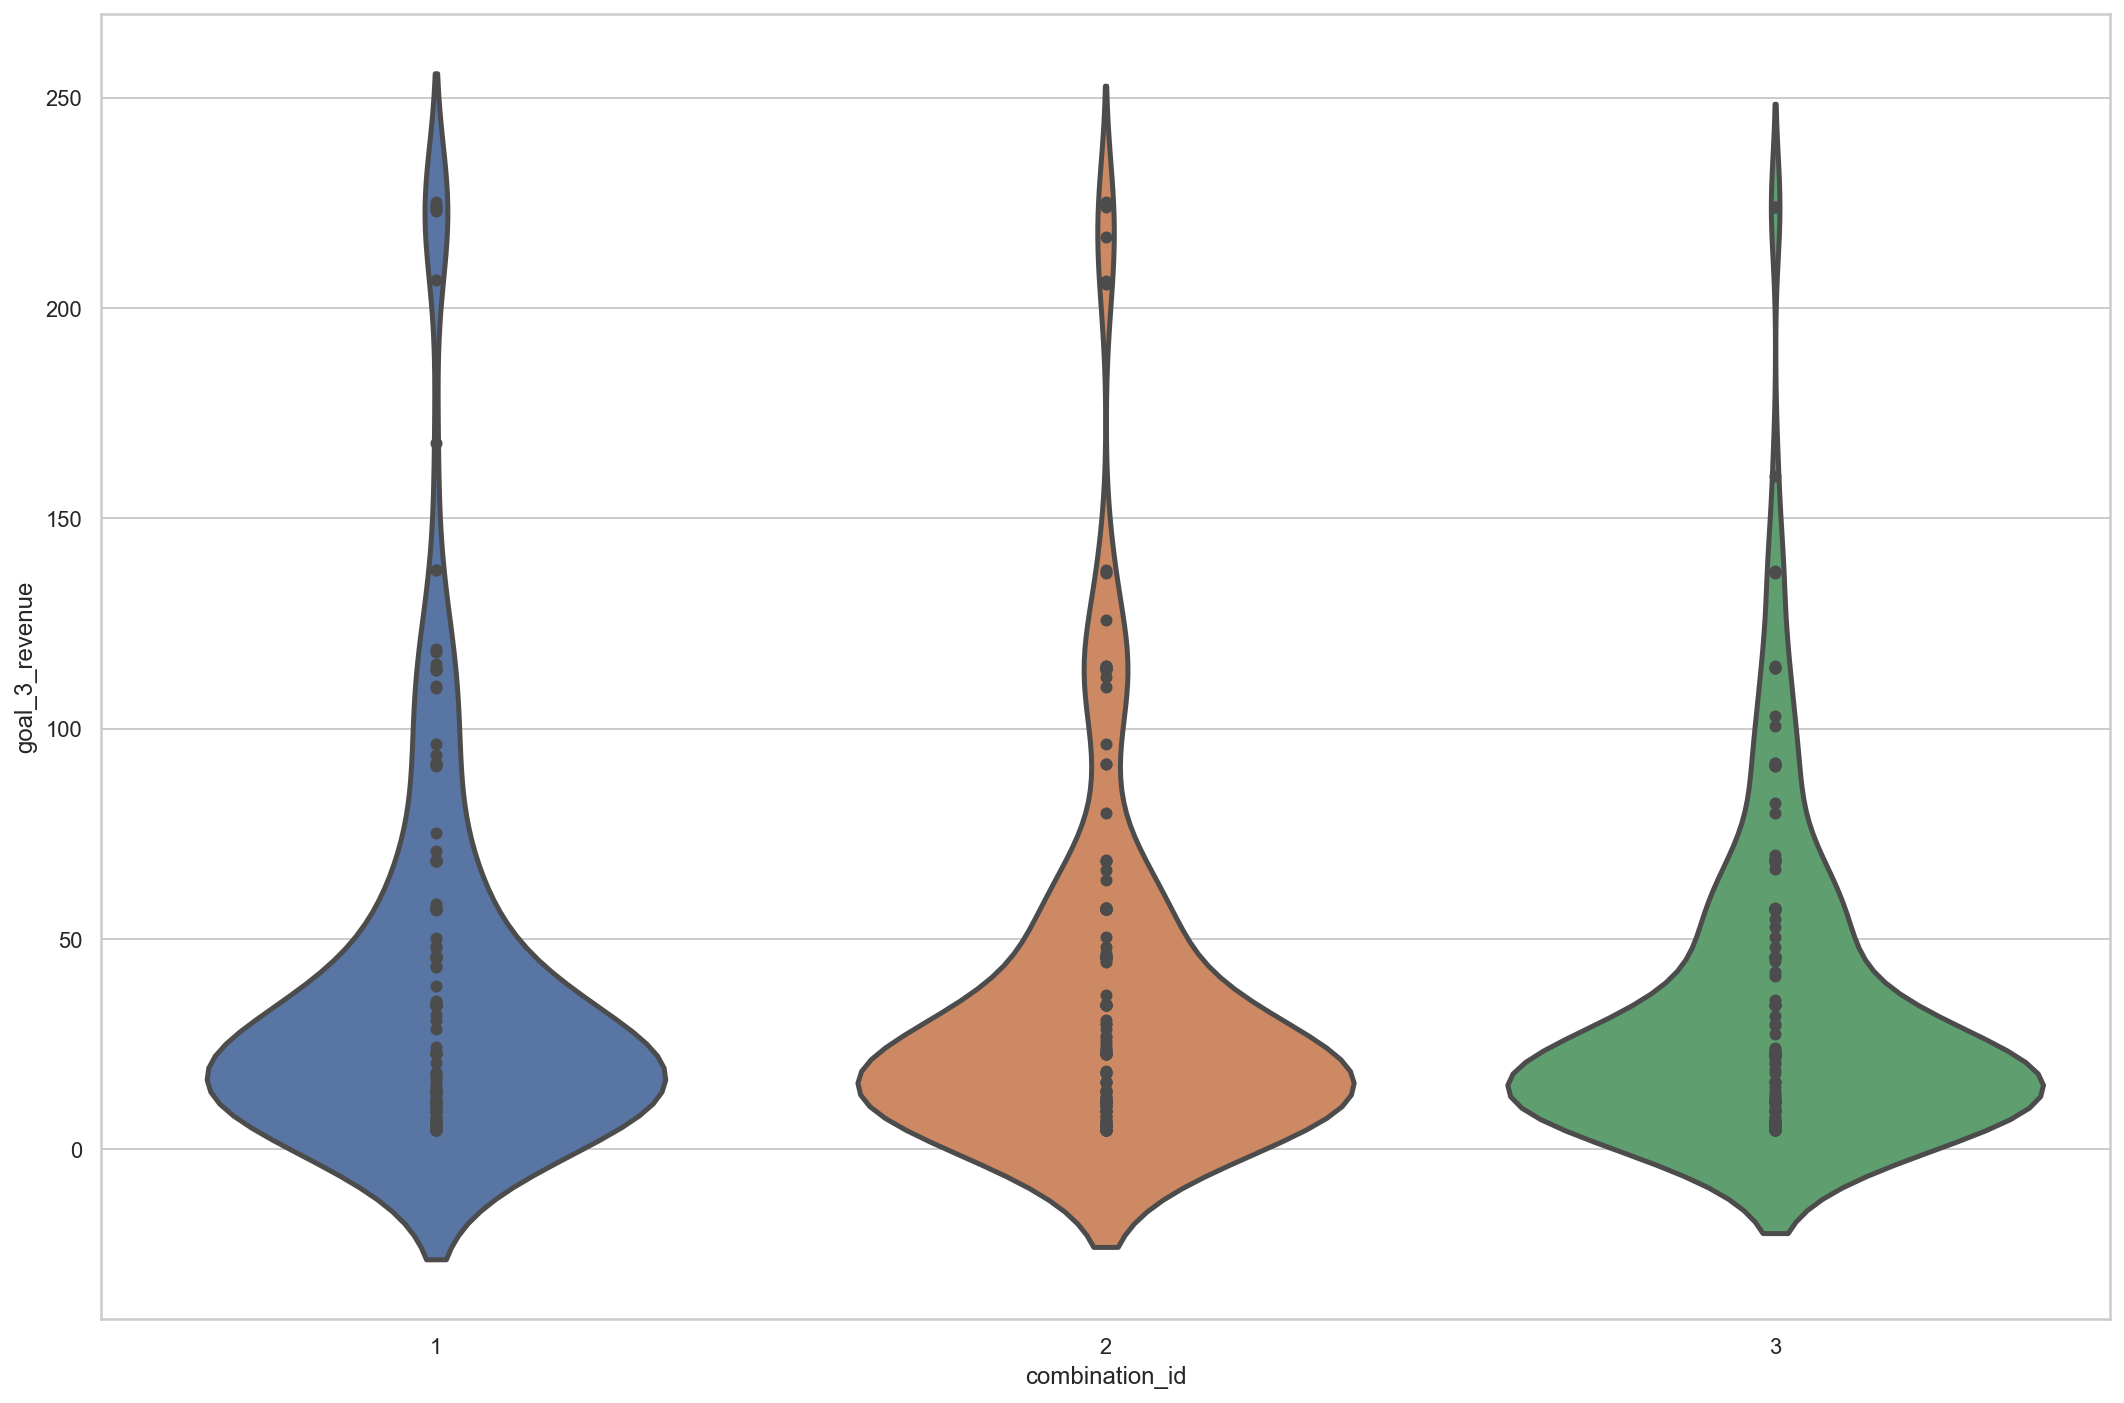

In [56]:
ax_nulls = plt.subplots(figsize=(18, 12))
ax_nulls = sns.violinplot(x='combination_id',\
                       y=df[revenue],\
                       data=df,\
#                        hue='os',\
                       linewidth=2.5,\
                       inner='point',\
                      )
# plt.axis([-1, 2, -75, 200])

## RUNNING EXPERIMENTS

In [57]:
import requests

url = "https://app.vwo.com/api/v2/accounts/{}/campaigns?status=RUNNING".format(FC)

headers = {
    "Accept": "application/json",
    "token": "90d8bd096a224e7f6b72a2000bab409d7a8063aba48d7a4424e9220de96483bd"
}

response = requests.request("GET", url, headers=headers)
json = response.json()

In [60]:
import requests
for x in [539414, 527076, 539416, 539420, 529239]:
    url = "https://app.vwo.com/api/v2/accounts/{}/campaigns?status=RUNNING".format(x)

    headers = {
        "Accept": "application/json",
            "token": "90d8bd096a224e7f6b72a2000bab409d7a8063aba48d7a4424e9220de96483bd"
}
    response = requests.request("GET", url, headers=headers)
    json = response.json()

In [62]:
exps = pd.json_normalize(json['_data'])

In [63]:
exps.query('status=="RUNNING" & type=="ab"').iloc[:, :10]

id                                                  name type platform  \
0  146  [PRT-360][Prod] Slotv рекомендательная система "ALS"   ab  website   
1  140            [SC-6665][ABT-58] Redesign of User Profile   ab  website   

    status   createdOn  isDeleted labels                        primaryUrl  \
0  RUNNING  1640007829      False     []  https://slotv.com/ru/games/slots   
1  RUNNING  1638533597      False     []              https://slotv.com/en   

                                                                                                  urls  
0  [{'type': 'pattern', 'value': 'https://slotv.com/*/games/slots'}, {'type': 'endsWith', 'value': ...  
1  [{'type': 'pattern', 'value': 'https://slotv.ro/*'}, {'type': 'pattern', 'value': 'https://slotv...

## CONNECT HEAPPO

In [278]:
import psycopg2
connect = psycopg2.connect(host="10.208.72.65", port = 6432, database="heappo", user="rodion_ter_ro_user", password="dv33msfu84ndjsh3bz7")
cur = connect.cursor()

In [279]:
cur.execute("""
SELECT * FROM gambling.vwo_experiments WHERE (campaign_id = 123)""")

In [280]:
colnames = [desc[0] for desc in cur.description]

In [281]:
query_results = cur.fetchall()
sql_stage = pd.DataFrame(query_results, columns=colnames)

In [282]:
sql_stage

vwo_uuid  user_id  campaign_id  \
0   D0BECCC30FA802E026FDCED4EDF509153        0          123   
1   D0BECCC30FA802E026FDCED4EDF509153    14420          123   
2   D0BECCC30FA802E026FDCED4EDF509153    14472          123   
3   D19C7825402079C8D905421DF425F740B        0          123   
4   D5C4D85FF9A896A88F503C56C36E9B228        0          123   
5   D79FDD104A6C9C32C4E3AEDEBE9ADBDF3        0          123   
6   D954E5D9AFCEE919FAFC96B55A897161C        0          123   
7   DBA8B9B13C28EC935B000A82D8DAC0CE3        0          123   
8   DED2F795D5F370974113EE2B2086AA6EF        0          123   
9   DED2F795D5F370974113EE2B2086AA6EF        0          123   
10  DED2F795D5F370974113EE2B2086AA6EF    12896          123   
11  DED2F795D5F370974113EE2B2086AA6EF    14275          123   
12  DED2F795D5F370974113EE2B2086AA6EF    15841          123   
13  DED2F795D5F370974113EE2B2086AA6EF    16034          123   
14  DED2F795D5F370974113EE2B2086AA6EF    16037          123   
15  DFBAD4C8B78B4F49EDA3E03A3BCE42A59        0          123   
16  DFBAD4C8B78B4F49EDA3E03A3BCE42A59        0          123   

              campaign_name campaign_type             variations  \
0   [SC] ABT-34 New Cashier            ab  [{'2': 'New Widget'}]   
1   [SC] ABT-34 New Cashier            ab  [{'2': 'New Widget'}]   
2   [SC] ABT-34 New Cashier            ab  [{'2': 'New Widget'}]   
3   [SC] ABT-34 New Cashier            ab  [{'2': 'New Widget'}]   
4   [SC] ABT-34 New Cashier            ab                     []   
5   [SC] ABT-34 New Cashier            ab     [{'1': 'Control'}]   
6   [SC] ABT-34 New Cashier            ab     [{'1': 'Control'}]   
7   [SC] ABT-34 New Cashier            ab  [{'2': 'New Widget'}]   
8   [SC] ABT-34 New Cashier            ab  [{'2': 'New Widget'}]   
9   [SC] ABT-34 New Cashier            ab                     []   
10  [SC] ABT-34 New Cashier            ab                     []   
11  [SC] ABT-34 New Cashier            ab  [{'2': 'New Widget'}]   
12  [SC] ABT-34 New Cashier            ab  [{'2': 'New Widget'}]   
13  [SC] ABT-34 New Cashier            ab  [{'2': 'New Widget'}]   
14  [SC] ABT-34 New Cashier            ab  [{'2': 'New Widget'}]   
15  [SC] ABT-34 New Cashier            ab  [{'2': 'New Widget'}]   
16  [SC] ABT-34 New Cashier            ab  [{'2': 'New Widget'}]   

                                                     goals            version  \
0                                                       {}  1636444015.934939   
1                                                       {}  1636018473.052552   
2                                                       {}  1635949337.783359   
3                                                       {}  1636130208.277771   
4                                                       {}  1635932675.318724   
5                                      {'2': 'engagement'}  1636369223.364676   
6                                      {'2': 'engagement'}  1636036804.228605   
7                                                       {}   1636124360.25595   
8                                      {'2': 'engagement'}    1636452362.4681   
9                                                       {}  1636460466.972378   
10                                                      {}  1636460452.467214   
11                                     {'2': 'engagement'}  1636369492.230248   
12                                     {'2': 'engagement'}  1636104503.089337   
13                                     {'2': 'engagement'}  1636106874.558825   
14                                     {'2': 'engagement'}  1636105384.755438   
15  {'2': 'engagement', '9': 'all_payment_systems_change'}  1635949038.228406   
16  {'2': 'engagement', '9': 'all_payment_systems_change'}  1635867119.473796   

            rest project_id              created_at              updated_at  
0   {'id': 1950}        sc1 2021-11-03 08:41:37.467 2021-11-03 14:21:05.664  
1   {'id': 1964}        sc1 2021-11-04 09:33:31.449 20

In [285]:
cur.close()
connect.close()

## DRAFT

In [118]:
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, CategoricalEncoder
ordinal_encoder = OrdinalEncoder()
hot_encoder = OneHotEncoder()


ImportError: cannot import name 'CategoricalEncoder' from 'sklearn.preprocessing' (/Users/rodiontereshkov/.local/lib/python3.8/site-packages/sklearn/preprocessing/__init__.py)

In [112]:
df_encoded = ordinal_encoder.fit_transform(df[['os', 'combination_name']])
df_hot_encoded = hot_encoder.fit_transform(df[['os', 'combination_name']])

In [113]:
df_encoded

array([[1., 0.],
       [1., 1.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 0.],
       [4., 1.]])

In [114]:
ordinal_encoder.categories_

[array(['android', 'ios', 'linux', 'mac_os_x', 'windows'], dtype=object),
 array(['control', 'variation_1'], dtype=object)]

In [116]:
df_hot_encoded.toarray()

array([[0., 1., 0., ..., 0., 1., 0.],
       [0., 1., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 1., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 1., 0., 1.]])

In [117]:
hot_encoder.categories_

[array(['android', 'ios', 'linux', 'mac_os_x', 'windows'], dtype=object),
 array(['control', 'variation_1'], dtype=object)]

In [119]:
list(df)

['screen_resolution',
 'query_parameters',
 'ip',
 'browser',
 'browser_version',
 'device_type',
 'device',
 'os',
 'os_version',
 'user_agent',
 'traffic_source',
 'combination_id',
 'combination_name',
 'converted',
 'goal_id',
 'conversion_time',
 'returning_visitor',
 'hit_time',
 'user_language',
 'url',
 'referring_url',
 'city',
 'region',
 'country',
 'custom_dimension',
 'goal_1_converted',
 'goal_1_converted_time',
 'goal_203_converted',
 'goal_203_converted_time',
 'goal_208_converted',
 'goal_208_converted_time',
 'goal_209_converted',
 'goal_209_converted_time',
 'day',
 'jurisdiction',
 'uuid',
 'hashed_user_id',
 'has_duplicates',
 'domain',
 'land',
 'land_number',
 '1_goal_secs',
 '203_goal_secs',
 '208_goal_secs',
 '209_goal_secs']

In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [103]:
mnist.data

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [104]:
X, y = mnist.data, mnist.target

In [105]:
X.shape

(70000, 784)

In [106]:
y.shape

(70000,)

In [99]:
y[36000]

'9'

In [68]:
np.random.permutation(100)

array([ 6,  9, 36,  4, 81, 55, 56, 38, 40, 74, 94, 39, 83, 59, 95, 24, 25,
       85, 44, 65, 20, 87, 34, 19, 63, 99, 62, 32,  7, 51, 49,  0, 77, 14,
       48, 10, 66, 31, 84, 90, 61, 54, 73, 11, 21, 75, 43, 96,  2, 15, 88,
       93, 13, 46, 47, 91, 78, 30, 71, 23, 70, 76, 26, 72,  8, 64, 86, 68,
        5,  3, 80, 28,  1, 27, 12, 17, 97, 50, 53, 67, 58, 18, 92, 98, 57,
       35, 42, 79, 16, 52, 82, 41, 22, 33, 37, 89, 60, 69, 29, 45])

In [107]:
from sklearn.linear_model import SGDClassifier
sgd = SGDClassifier(random_state=42)

(-0.5, 27.5, 27.5, -0.5)

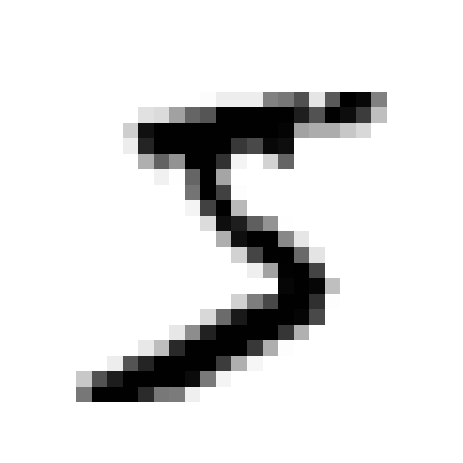

In [108]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap=mpl.cm.binary)
plt.axis("off")

plt.show()

In [109]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [110]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [119]:
from sklearn.linear_model import SGDClassifier

sgd = SGDClassifier(random_state=42)
sgd.fit(X_train, y_train)

SGDClassifier(random_state=42)

In [116]:
X_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [118]:
y_train_5

array([False, False, False, ..., False, False, False])

In [125]:
sgd.predict(y_test[:, np.newaxis])

ValueError: X has 1 features, but SGDClassifier is expecting 784 features as input.

In [126]:
y_test[:, np.newaxis]

array([['7'],
       ['2'],
       ['1'],
       ...,
       ['4'],
       ['5'],
       ['6']], dtype=object)

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [4]:
mnist

{'data': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 'target': array(['5', '0', '4', ..., '4', '5', '6'], dtype=object),
 'frame': None,
 'categories': {},
 'feature_names': ['pixel1',
  'pixel2',
  'pixel3',
  'pixel4',
  'pixel5',
  'pixel6',
  'pixel7',
  'pixel8',
  'pixel9',
  'pixel10',
  'pixel11',
  'pixel12',
  'pixel13',
  'pixel14',
  'pixel15',
  'pixel16',
  'pixel17',
  'pixel18',
  'pixel19',
  'pixel20',
  'pixel21',
  'pixel22',
  'pixel23',
  'pixel24',
  'pixel25',
  'pixel26',
  'pixel27',
  'pixel28',
  'pixel29',
  'pixel30',
  'pixel31',
  'pixel32',
  'pixel33',
  'pixel34',
  'pixel35',
  'pixel36',
  'pixel37',
  'pixel38',
  'pixel39',
  'pixel40',
  'pixel41',
  'pixel42',
  'pixel43',
  'pixel44',
  'pixel45',
  'pixel46',
  'pixel47',
  'pixel48',
  'pixe

In [5]:
mnist.feature_names

['pixel1',
 'pixel2',
 'pixel3',
 'pixel4',
 'pixel5',
 'pixel6',
 'pixel7',
 'pixel8',
 'pixel9',
 'pixel10',
 'pixel11',
 'pixel12',
 'pixel13',
 'pixel14',
 'pixel15',
 'pixel16',
 'pixel17',
 'pixel18',
 'pixel19',
 'pixel20',
 'pixel21',
 'pixel22',
 'pixel23',
 'pixel24',
 'pixel25',
 'pixel26',
 'pixel27',
 'pixel28',
 'pixel29',
 'pixel30',
 'pixel31',
 'pixel32',
 'pixel33',
 'pixel34',
 'pixel35',
 'pixel36',
 'pixel37',
 'pixel38',
 'pixel39',
 'pixel40',
 'pixel41',
 'pixel42',
 'pixel43',
 'pixel44',
 'pixel45',
 'pixel46',
 'pixel47',
 'pixel48',
 'pixel49',
 'pixel50',
 'pixel51',
 'pixel52',
 'pixel53',
 'pixel54',
 'pixel55',
 'pixel56',
 'pixel57',
 'pixel58',
 'pixel59',
 'pixel60',
 'pixel61',
 'pixel62',
 'pixel63',
 'pixel64',
 'pixel65',
 'pixel66',
 'pixel67',
 'pixel68',
 'pixel69',
 'pixel70',
 'pixel71',
 'pixel72',
 'pixel73',
 'pixel74',
 'pixel75',
 'pixel76',
 'pixel77',
 'pixel78',
 'pixel79',
 'pixel80',
 'pixel81',
 'pixel82',
 'pixel83',
 'pixel84',
 

In [6]:
np.sqrt(784)

28.0

In [42]:
a = 18.20

In [43]:
b = 15.25

In [47]:
positive_improvement = 100-(b*100/a)
round(positive_improvement)
round(positive_improvement).to_clipboard()

16

AttributeError: 'int' object has no attribute 'to_clipboard'

In [30]:
19.89 + 13.49

33.38

In [37]:
round(a*100/b)

18